# Understanding the Reaction to Amazon Prime Air (Or: Tapping Twitter's Firehose for Fun and Profit with *pandas*) 

On Cyber Monday Eve, Jeff Bezos revealed that Amazon may have intentions to one day deliver many of its goods by unmanned aerial vehicles through a service called *Amazon Prime Air* as part of an segment for the television show *60 Minutes*. This notebook explores ~125k tweets from Twitter's firehose that were captured shortly after the announcement and teaches you how you can be equipped to capture interesting data within moments of announcements for your own analysis.

<br />
<center><iframe width="560" height="315" src="//www.youtube.com/embed/98BIu9dpwHU" frameborder="0" allowfullscreen></iframe><br /><center>
<br />

## Aspire

Let's seek to better understand the "Twitter reaction" to Amazon's announcement that drones may one day be delivering packages right to our doorsteps.

## Acquire

Twitter is an ideal source of data that can help you to understand the reaction to newsworthy events, because it has more than 200M active monthly users who tend to use it to frequently share short informal thoughts about anything and everything. Although Twitter offers a Search API that can be used to query for "historical data", tapping into the firehose with the Streaming API is a preferred option because it provides you the ability to acquire much larger volumes of data with keyword filters in real-time.

There are numerous options for storing the data that you acquire from the firehose. A document-oriented database such as <a href="http://www.mongodb.org/">MongoDB</a> makes a fine choice and can provide useful APIs for filtering and analysis. However, we'll opt to simply store the tweets that we fetch from the firehose in a newline-delimited text file, because we'll use the *pandas* library to analyze it as opposed to relying on MongoDB or a comparable option. 

Note: Should you have preferred to instead sink the data to MongoDB, the *mongoexport* commandline tool could have exported it to a newline delimited format that is exactly the same as what we will be writing to a file. Either way, you're covered.

### Python Dependencies

There are only a few third-party packages that are required to use the code in this notebook: 

* The *twitter* package trivializes the process of tapping into Twitter's Streaming API for easily capturing tweets from the firehose
* The *pandas* package provides a highly-performant "spreadsheet-like interface" into large collections of records such as tweets
* The *nltk* packages provides some handy functions for processing natural language (the "140 characters" of content) in the tweets

You can easily install these packages in a terminal with *pip install twitter pandas nltk*, or you can install them from within IPython Notebook by using "Bash magic". Bash magic is just a way of running Bash commands from within a notebook as shown below where the first line of a cell prefixed with *%%bash*.

In [1]:
%%bash

pip install twitter pandas nltk

### Tapping Twitter's Firehose

It's a lot easier to tap into Twitter's firehose than you might imagine if you're using the right library. The code below show you how to create a connection to <a href="https://dev.twitter.com/docs/streaming-apis">Twitter's Streaming API</a> and filter the firehose for tweets containing keywords. For simplicity, each tweet is saved in a newline-delimited file as a JSON document.

In [10]:
import io
import json
import twitter

# XXX: Go to http://twitter.com/apps/new to create an app and get values
# for these credentials that you'll need to provide in place of these
# empty string values that are defined as placeholders.
#
# See https://vimeo.com/79220146 for a short video that steps you
# through this process
#
# See https://dev.twitter.com/docs/auth/oauth for more information 
# on Twitter's OAuth implementation.

CONSUMER_KEY = 'k7TcWQNvLAFw6UHp8b6tjSfys'
CONSUMER_SECRET = 'HoJ4C5Qgb0kGpt1NkPp4RAuInseNYOHLXOXrpksAU7jwRdW2ZY'
OAUTH_TOKEN = '105425189-p1Oif8hdJ4RXuN35mbPfH81onaVScOaziCefbRxJ'
OAUTH_TOKEN_SECRET = '8gikBBD7lRt7mbGG9JO5Yfy9kMS4OjesrN0UQIZaOEJOI'

# The keyword query

QUERY = 'Amazon'

# The file to write output as newline-delimited JSON documents
OUT_FILE = QUERY + ".json"


# Authenticate to Twitter with OAuth

auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

# Create a connection to the Streaming API

twitter_stream = twitter.TwitterStream(auth=auth)


print('Filtering the public timeline for "{0}"'.format(QUERY))

# See https://dev.twitter.com/docs/streaming-apis on keyword parameters

stream = twitter_stream.statuses.filter(track=QUERY)

# Write one tweet per line as a JSON document. 

with io.open(OUT_FILE, 'w', encoding='utf-8', buffering=1) as f:
    for tweet in stream:
        f.write(str(u'{0}\n'.format(json.dumps(tweet, ensure_ascii=False))))
        print(tweet['text'])

Filtering the public timeline for "Amazon"
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
Kashmir by Led Zeppelin

https://t.co/eF6gW2Wtkg
RT @decameron1349: Choisie sur Amazon... 😎🌹😁 https://t.co/EshX5xNgn2
awarenessxx: “【パヨクが発狂】 青林堂刊『余命三年時事日記』が、 Amazonで１週間連続で本部門総合１位を記録” — 正義の見方◇2015年12月27日... https://t.co/anUHDnt9xB
What do you think of this? Lovecraft horror anthology free for a bit
https://t.co/BmHvrrm7jt
RT @chuletito1946: A TYRANNY OF GOD
https://t.co/4BOjSewylf
https://t.co/JRP6QkifBC
Barnes &amp; Noble, Kobo, other booksellers. #HistoricalFic…
#USA 21% off, 4.5 Stars: Dragon Touch Inch  Intel Bits Quad Core Android Tablet R.... Top Review said: I'm really h… https://t.co/C9u8SjoS19
PM sells Trans Mountain pipeline as Amazon announces expansion in Vancouver https://t.co/hHa5woa9nV
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl

RT @EllieEmerson8: Now available in paperback or ebook on Amazon! #paranormalromance, #occultfiction, #fredericksinn! https://t.co/ouzBO5eJ…
RT @DancingLemurPre: Listen to Dragon on the Stars by @alexjcavanaugh best-seller on audio  iTunes- https://t.co/z9absRSUl8 Audible- https:…
RT @popolo_PR: 【#カウントダウンキャンペーン③】
配信直前カウントダウンキャンペーン！
当イートをリツイート＆公式アカウントをフォローしてAmazonギフトカードをGETしよう！
応募期間：5月6日23:59 まで！抽選で3,000円分を1名様に！
事前登録はコ…
RT @SpatialAce: How's this for accessible #OpenData? @JohnsCreekGAgov has connected theirs to #Alexa from #Amazon https://t.co/i2Af1BVRbN #…
#水出し だから実現した、透明感のあるコク。「ジョージア ジャパン クラフトマン」を私は #これから見つける ！あなたは？今なら、 @GEORGIA_JAPAN をフォロー ＆ #2択でツイート で300名様にAmazonギフト券… https://t.co/fAKxxRkr0u
RT @TK_staff: 6月27日(水)小室哲哉作品集「TETSUYA KOMURO ARCHIVES」発売決定！
TM NETWORK、渡辺美里、篠原涼子からAAA、PANDORAまで
レーベルの枠を超え100曲が収録！ https://t.co/k7DggfMfm3
h…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @barbaralongley: "Loved this book! Romance,

RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
RT @riywo: もうすぐ行ってきます！ / “VancouverにあるAmazon S3チームのDeveloperになります · As a Futurist...” https://t.co/uqmIgZIOwl
RT @aklove1111: MY Premium XXX SC SPECIAL.. only $15…ONE TIME PAYMT...Lifetime access. Fucking, sucking, girl on girl, and more. GooglePay,…
【最大10万円が当たる！！】
無料で10周年キャンペーンに参加しよう♪

200万人以上が利用しているポイントサイト『ポイントインカム』で今日からお小遣いアップ！
▼ココから1分無料登録▼
https://t.co/xZQ3ve8XEF
#ポイント #Amazon#オススメ
かわいい黒猫のロンダ君。リンゴがまったく諦められません。今度は本を積み上げて挑戦ですが、本の数が足りません。寂しくリンゴを見つめます。そんな情景が表現されたiPhone6Plusケースhttps://t.co/V2ulkC2Az1… https://t.co/SMqo9U788q
貯めたポイントは現金やAmazonギフト券へ交換。手数料無料。サイト経由をして買うだけでお小遣いGET。ヤフオク出品/落札。まずは登録。⇒https://t.co/s9xKEXtxL9
Hape E3100 - Cucina Bianca da Chef sceso a 79,07€ con un ribassamento pari al 8.72%! #Ama

RT @kitacjp: 本日より開始！「ジャグラーアプリ発売記念RTキャンペーン」フォロー＆RTで100様に“amazonギフトコード1000円分”が当たる！さらに抽選で１名に“BOSEスピーカー”をプレセント! https://t.co/dUuUGBBJie  #スロット…
RT @V2CigsUK: Treat yourself to something from your wishlist with our £20 Amazon voucher #giveaway! To enter to #win just follow + RT! http…
RT @22_Minutes: Amazon bringing 3000 new tech jobs to Vancouver. And they'll be there by Wednesday if you order them with Amazon Prime.
RT @NCRIUS: Read the chilling account of a prisoner of 11 yrs who miraculously survived the massacre of 30,000 political prisoners by those…
The War on Big Retail Is Nothing New https://t.co/Wz5w7VSw97
RT @lynnv378: There he goes again. Team Trump. Hey Bernie what did you pay in taxes? Release your taxes. https://t.co/Je2S2dehTE
#USA 20% off, 5.0 Stars: Peekaboo Pet Dog Seat  Cover Hammock Back Seat Side Fla.... Promotions: $10.00 off #Time L… https://t.co/ZrTx33r3Uc
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
Thi

RT @Sharpe_TV: Monthly Giveaway!!

Win £20 Voucher for Steam, PS4, Xbox, Amazon 

Just click here: https://t.co/ufNQAbQLws 

#Giveaway #Vou…
RT @choucho0115: amazonがあらゆるボドゲ をこれでもかとすすめてくる… https://t.co/5M5oq0RbHD
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @coretabe: いよいよ本日ラスト！
最終日なので今日だけ2名様にします

#コレタベ29日目
✅今日は4月30日(月)　23時59分まで！

㊗️リリース記念第3弾フォロー＆ #RTキャンペーン
＼毎日1名様に／#Amazonギフト券 500円分が当たる

▼応募…
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
I entered a Monthly Giveaway!!

Win £20 Voucher for Steam, PS4, Xbox, Amazon 

Just click here:… https://t.co/nekTWYuSub
RT @cashalphaJ: Here are my tribute methods, now there's no excuse get funding my social life🖕

Cashalphaj@gmail.com

£cashalphaj

https://…
おうちでできる除毛エピ！サロン同様の光美容器です！→Braun (ブラウン) の ブラウン 光美容器 シルクエキスパート BD-5001 を Amazon でチェック！ https://t.co/2H2ZLpfAtT @amazonJPさんから
RT @christy_a

RT @yosuke_kosuke: 【あと2日！】

5/2(水)発売！
ヨースケコースケ「アルビレオ」
いよいよ明日は店着日です！

★GWに5ヶ所でリリースイベント開催！

★タワーレコード・Amazon：予約特典有り！ご予約お忘れなく！

★アニメイト：先着購入者にオリ…
RT @VoiceOfIndie: MEET VASHTI-QUIROZ-VEGA @VashtiQV Fantasy, Suspense/Thriller &amp; Horror writer, BLOG: /1g0da7d  https://t.co/P23lka2DBz  AM…
スクールアイドル練習着風Tシャツ　はなまるちゃん（国木田花丸　風）
https://t.co/TONJ29YWaQ … … …  
#国木田花丸
#USA 37% off, 4.4 Stars, 277 Reviews: Holy  Stone Hs110 Wifi Fpv Drone Adjustable Hd Camera Live.... Promotions: $1… https://t.co/JmAxsXKes4
RT @ryushokanbook: 6/8（金）19:00〜隆祥館書店にて『国体論―菊と星条旗』集英社刊行記念トーク・イベント
「国体」の呪縛とは何か？
著者　白井聡  × ゲスト大澤聡
白井聡さんの新刊はもちろん、大澤聡さんの新刊『教養主義のリハビリテーション』のサイン会も…
#水出し だから実現した、透明感のあるコク。「ジョージア ジャパン クラフトマン」を私はお店で #見つけた ！あなたは？今なら、 @GEORGIA_JAPAN をフォロー＆ #2択でツイート で300名様にAmazonギフト券当た… https://t.co/UAwbWOXZTP
RT @Dixonverse: Lotta my stories in this one! https://t.co/0MwugibB7U
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
RT @Sen

RT @popolo_PR: 【#カウントダウンキャンペーン④】
配信直前カウントダウンキャンペーン！
当ツイートをリツイート＆公式アカウントをフォローしてAmazonギフトカードをGETしよう！
応募期間：5月7日23:59 まで！抽選で3,000円分を1名様に！
事前登録は…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
Learn Business English: #ESL #LearnEnglish  #BusinessEnglish Check out the E-Book: https://t.co/RxJDs6x8Wt
RT @Marie_N_Vianco: ¿Se puede opacar el brillo de una estrella? 
Descúbrelo en: LOS DESTELLOS DE SARA 
Capítulos gratis en
https://t.co/uEJ…
RT @AmazonPub: The gates that guarded their love are open, but a new secret will change everything she once knew. @authorJSScott https://t.…
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
RT @SenSanders: You know what Amazon paid in federal income taxes last yea

Get "Save Me Twice" in exchange for an honest review. Who wants to read it? ✋👌 #Historical #WWII #TrueEvents… https://t.co/SpchPP6yHN
ANAGRAM アナグラムの翌日配送対象エリア
【公式】ANAGRAM アナグラム　
https://t.co/jzJAN8gcaC
[ANAGRAM アナグラム Amazon店]
https://t.co/j91kCRgU3F https://t.co/zPWKoDwDOF
The Hometown Series Book Tour: Enter to #win a $15 Amazon Gift Card! #Giveaway ends 5/25 https://t.co/k7ihJ6QEIP https://t.co/FWYAEC15xd
Netflix and Amazon join the battle against Kodi pirates: https://t.co/EIa0zI4YiL
Four ways to maximize Amazon's social marketing power. https://t.co/JkWqGTjwW8

#DigitalMarketing #DigitalMarketer… https://t.co/YxzMtcDyJM
Amazon:
✴️ iPega Gamepad
🎟Cupón: Incluido
❌Antes: $1,039Mxn ✅PROMO: $602Mxn 
Compatibilidad con Android y IOS, hast… https://t.co/ad55SVnLOK
5/1イベント
 木と闇の犬龍ドロップ2倍
　#爆速メタドラ時間割 大人気のパズドラ時間割　https://t.co/OTciiNiynz
"Taming Your Temper" (Visit Amazon to buy) https://t.co/i5FjF0Tm01
For Prologis Inc., the world’s largest warehouse owner, the biggest challenge to growth has

RT @sai_zen_sen: 【告知】傑作百合ノベルゲーム『FLOWERS -Le volume sur printemps-』、小説版第１巻の内容をご紹介！  Amazonでは予約が始まっております。そして、スギナミキさん描き下ろしによるカバーイラストを大公開！ http…
RT @Nate_Nyo: The fact that @MangaDex has a link to Amazon Japan releases of the manga is the most amazing, wonderful thing. Makes it super…
RT @thenorthrmembrs: @Neets101 @ummitsamelia @SenSanders https://t.co/S0bALpyxsc
To commemorate Bette Davis' 100th birthday, Warner Brothers are releasing six films  
 https://t.co/y6vfm1WcGO
【インクカートリッジ】ベスト10
EPSON 純正インクカートリッジ  ICBK80L ブラック 増量(目印:とうもろこし)
https://t.co/zFOnmtkopG #Amazon
YA ESTA A LA VENTA lo nuevo de Códice "TE PERDI PARA SIEMPRE"

DESCARGALO YA !!!

ITUNES: https://t.co/7gzAloVN1b
A… https://t.co/VX2nMPp6pP
Los robots se están volviendo cada vez más parte de nuestras vidas y Amazon lo sabe https://t.co/4b5tWXZAw2 https://t.co/9Pzeksc4Gn
Welcome to my baby registry. Any help would be great! Thanks in advance♥️ https://t.co/xKuTRl8oUm
気にはなってるけど、あんまり話題になってないような。スマホと同じぐらいかちょっと安いかも、なんだよね https://t

RT @sarahmcgbeauty: I'm just saying, with all the talk about how Amazon is taking over the world lately, things are starting to feel eerily…
RT @SavvyAuthors: Worldbuilding for More Than Fantasy with Amazon Bestselling Author Lisa Kessler @LdyDisney https://t.co/9v2bcIny8l May 21…
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
I get to try @SeventhGen Free &amp; Clear Wipes free in their #generationgood community. Ck them out on Amazon too! #Ad https://t.co/W7zv7P8Vm1
Love Fantasy &amp; SciFi? #Win a $100 #Amazon #GiftCard in April's mega #BookBub #Giveaway via @sffbookbonanza: https://t.co/mADAFhwZVi
RT @popolo_PR: 【#みんなの言葉キャンペーン】
秋葉原屋外ビジョンで最新動画を配信中！
フォロー&amp;RTで応募または、ビジョン広告を撮影して #みんなの言葉キャンペーン をつけて投稿！
抽選で10名様に3,000円分のAmazonギフトカードをプレゼント！
期間：5…
A Killing in Capone's Playground: The True Story of the Hunt for the... https://t.co/q4cwJ0EO1z #Amazon
RT @danhancox: Here's the cover of my next

Amazon to open new 416K square-foot office in Vancouver, will hire for 3,000 new jobs

https://t.co/56Z6EjjtlQ https://t.co/tCsrsZWFKP
Animal Planet's Big Tub of Dinosaurs

Animal Planet's Big Tub of Dinosaurs
From Hasbro
 https://t.co/0XW5AlzPiy https://t.co/WwaaoQivkL
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @nyanyainu: 【宣伝】痴漢電車で堕ちてゆく
菜波・中田恵/TL小説
https://t.co/3n4BD4LCGK
気持とは裏腹に、私の身体はひどく感じていた。こんな痴漢の手によって。
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
A Killing in Capone's Playground: The True Story of the Hunt for the... https://t.co/28PEt1pljm #Amazon
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
No joke: On Amazon someone is trying to sell the A7III for $16,000!!! #photographer https://t.co/julMnUiOE4
Tortious Confetti... https://t.co/vn2AIF3oxl via @amazon #naturecuts #confetti #cutout #rept

Yes! Pure Protein® gives me the energy I need to #KeepOnTrack and accomplish my goals! Purchase on Amazon! #ad https://t.co/IMX7XPzMaz
Amazonに書籍が並んだ瞬間からあなたの肩書きは「著者」です。
 今までではそう簡単に手に入れる事のできなかった肩書きも、Kindle出版ならあなたも例外なく手に入れる事が可能になります。
仮面女子　神谷えりなを一緒に応援しませんか？*｡٩(ˊωˋ*)و*｡
https://t.co/X0ybOMHrQw
神谷えりなソロ1st写真集【神乳】
Amazon⇒https://t.co/zVF8bMhBko 
楽天⇒https://t.co/D88ub87BAO
アマゾンでカルマルカ*サークル 完全生産限定版 - PS4 (【特典】B2タペストリー &amp;【https://t.co/cxpwsnvPrt限定特典】ポストカード3種セット ... が予約受付中だよ！
2018年05月24日発売… https://t.co/etV0EqMWQy
@HORCHATAAAAAAAA No mammes lmao at amazon yea right they gon have the whole news there 😂😂😂
RT @author_SherrieB: RT @EJShawWriter    Have you ever seen a ghost? Eden Matthews has. But then her life isn't quite going as planned...
N…
Outrageous https://t.co/8EA8tHGWTG
#USA 23% off, 4.3 Stars, 135 Reviews: Vonshef Digital Black Fryer  Healthy Cooking. Details: Deliciously fry, roast… https://t.co/JdzW0Q5ng7
RT @okanenotsubo: 🎁プレゼント企画🎁
お好きなギフト券500円分
(写真の4種類の中から選べます)

応募方法：フォロー＆リツイート
締切：5/1

矛盾承知の橋下発言　／ https://t.co/ZDGsWVPBGQ
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
Amazon touts 100M Prime users as Apple quietly passes a quarter-billion paid subscriptions #technology… https://t.co/bf2rIQxH0R
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
当たりがすぐわかるのは緊張するー https://t.co/Uu3gUAuzCd
RT @domioriha: 図書館の大魔術師(1) (アフタヌーンKC)   泉 光 https://t.co/rbRYqXg1ex @amazonJPさんから

そう言えばねこれね、カスタマーレビュー２８件で圧倒的星５多数なんだけどマジでめっちゃ良かったね。ありえないくらい…
#Amazon #Deals $34.89 (Reg $51.99) #Mucinex 12 Hr Chest Congestion Expectorant, Tablets, 100ct Box (aff)… https://t.co/KiOSeHZpbl
RT @KimmySchmidt: 2018 is looking Kimmier than ever! What's your unbreakable New Year's resolution? https://t.co/fC6OE14Bpe https://t.co/Zc…
RT @hobbspond: RETREADS by Steve Hobbs
Always Free(!) on KU

予約販売スタート！ぜひご予…
Check out The Unforgiven by Metallica on Amazon Music
https://t.co/wGD6VIoU5t #세훈_범인은바로너
RT @emmalou13: "A beautiful and moving story. It had me blubbing so many times but it definitely makes you think about making the most of e…
7 Annoying Things That Sum Up My Relationship With Amazon Echos Alexa. [https://t.co/wvxcDj1qlg] #Amazon https://t.co/aXTbKXz225
11% OFF Kindle Paperwhite Essentials Bundle #DillyDilly https://t.co/LsuawJyxF0
久松郁実カレンダー2018 https://t.co/dGgbVZN0pU #amazon #俺ススメ #アマゾンポチ
モンスト高速自演招待代行いたします！ Amazonギフトの先払いのみ対応いたします。 料金は 2000円→50回 3000円→80回 4000円→110回 となっております！ 気になるは方リプかDMにてお願いします！実績わお気に入りにあります！yu
Esta semana está en el #Top5 de los #libros más vendidos: "Piel de letra", escrito por: Laura Escanes

➡️… https://t.co/cG1DpjkxtA
Amazon leads over Flipkart in India but the gap is narrowing https://t.co/mxDvA32VIj #digitalketchup
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @AthenaMatherly: F

RT @Bella623: Undertow: Death's Twilight is now available on #audiobook! 
Get your #audiobook copy of Undertow here: 
Amazon: https://t.co/…
Wow this is super exciting! https://t.co/NSMZzRoPLN https://t.co/NSMZzRoPLN
RT @mahiru0107gmai1: 送信できてなかった😰

おはようございます
朝のさや姉タイム🍀

#さや姉タイム
#山本彩
#NMB48 
#欲望者    発売中☺
https://t.co/QZeLSpZqyA
https://t.co/GIi6jd7D3G

#エ…
RT @KonnichiwaFest: Nos encanta la versión de colección 😍 ¿Ya tienes la tuya?
Amazon: https://t.co/SUn8EdnLAG
Kichink: https://t.co/2nTPyrD…
3 ways to listen to my #audiobooks
https://t.co/xtcSDjUPpv
1) #Free with an Audible 30-day trial. Cancel anytime. K… https://t.co/dvp7gEZ39g
RT @romance_sangoku: 「冥剣・暗牙」の皆さんの素晴らしいレコードを集めた。皆さん本当にうまい！またクリアしてない方もぜひ参考にしてください~

皆さんも自分のバトルレコードをシェアしてねっ！

RTお願い、1名様にAmazonギフトカード2000円分をプレゼ…
iTunesカードやAmazonギフト券が実質無料で買える！！
先着5様に各種ギフト券を3000円ご購入で3000円分のギフト券をプレゼント！実質無料に購入頂けます☆
通常販売もお得！【1万円分のギフト券を8500円で販売！】
購入をご希望の方はDMからご連絡ください
#ギフト
RT @GeoFwd: What is an ASIN? Check Amazon’s blog post explaining it: https://t.

RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
あなたの知識や経験が一冊の本になる！
「誰でも書ける・実用本の書き方」
ベストセラー作家も絶賛の内容で、あなたも作家デビュー！
https://t.co/ZP9PxS5rHq
RT @ExteriorID: ❤️DEESS laser hair removal; 3 cartridges to treat aging and acne (beat 3 at once!). Easy to use (Fitzpatrick scale I to V)+…
RT @ExteriorID: ❤️DEESS laser hair removal; 3 cartridges to treat aging and acne (beat 3 at once!). Easy to use (Fitzpatrick scale I to V)+…
RT @ExteriorID: ❤️DEESS laser hair removal; 3 cartridges to treat aging and acne (beat 3 at once!). Easy to use (Fitzpatrick scale I to V)+…
RT @ExteriorID: ❤️DEESS laser hair removal; 3 cartridges to treat aging and acne (beat 3 at once!). Easy to use (Fitzpatrick scale I to V)+…
RT @ExteriorID: ❤️DEESS laser hair removal; 3 cartridges to treat aging and acne (beat 3 at once!). Easy to use (Fitzpatrick scale I

@cocoseka_info #ココセカ
#英語とクイズのココロセカイ
#Amazonギフト券
英語大好きです😘❤️
これで苦手意識を持ってる人が楽しく学べるといいですよね✨
ご縁がありますように💕💕
毎日無料でポイントを貯めてiPhone/AndroidでAmazonギフト券やiTunesカードに変えられるアプリ「アルぱっか〜ん」アプリで招待コードを入力してくれたらポイントもらえますよー！
”CTJPO3”と入力して！
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @Accident_Advice: Accident Advice Helpline April prize draw. Follow us and F &amp; RT our daily posts for a chance t… https://t.co/aFJrCbDAGy
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @kelnew86: RT and follow me to be in with a chance of winning a £15 Amazon EVoucher! #competition ends 16/05 at 11:59pm. Good luck ☘️☘️…
Amazon to add 3,000 Vancouver tech jobs via Hub expansion https://t.co/94TYf28X7j #tech #startup
Amazon News Roundup: Prime Membership Bumped Up To $119, But Will People Care? https://t.co/sG3b4BB0N1
RT @Qrais_Usagi: 4コマ漫画スキウサギ「ゴールデンウィーク」https://t.co/6XVJs2hgjU　　単行本「スキウサギ1」発売中→https://

pls enjoy this amazon wishlist of art supplies i curated 
https://t.co/E4XvfYkcRM
Love In Bloom Clean Romance Event - $100 Kick-Off Giveaway - Enter to win Paypal Cash or an Amazon Gift Code! https://t.co/l9SwJdNceu
RT @JShamess: Toronto HQ2 closer? Or locational spillover to Seattle - @JustinTrudeau announces new @amazon Vancouver headquarters to bring…
RT @princejerundio: Bientôt ils vont même t’emmener au travail https://t.co/8nk5eZfPIB
Amazon News Roundup: Prime Membership Bumped Up To $119, But Will People Care? https://t.co/SHbrj4seYz
RT @BustyScarlettV: Nice little something before I sleep 

Now who's gonna put the smile on my face when I wake up 😊

Amazon gift card sent…
#USA 29% off, 4.3 Stars: Ebbo 131 Compatible  Toner Cartridges Replacement For Canon.... Details: Why choose EBBO:… https://t.co/HloMWJuAgJ
RT @Ianwilfred39: Carole Maggie and Caroline had more than #MondayMotivation when they said goodbye to the husbands and hello to fun
 https…
#Canada 15% off, 4.4 Stars: Iph

モンスト ルシファーとアーサー
運極は30体のアカウント欲しい方連絡お願いいたします！！

写真はDMのみです！！
連絡はDMでお願いいたします！！
Amazonギフトカードでの交換！！
値段交渉します！！
先送りのみです！！！！！！！
RT @paupasdf: @IneeesL Este spray tiene apariencia de pintalabios de barra, y da para 10 usos con un rango de 3 metros, así que no hace fal…
潜水艦を操って、3D海戦に挑む 任天堂(3DS)  「STEEL DIVER」 詳細＆予約受付！ https://t.co/H6yFQ1uqsO　　#3DS #DS #followmejp #videogame  #amazon
#USA 23% off, 5.0 Stars: Cedarcraft  Folding Potting Bench &amp; Event Table. Details: Ideal for outdoor gardening or b… https://t.co/TmE91esMVL
RT @AboutTheRent: Don't Worry About The Rent: Choosing new office space to boost business performance #tenant #commercialrealestate #busine…
可愛い過ぎる韓国リュック✨ [デーライフ] Daylife Multi Pocket Backpack 男女共用 メッシュ バックパック [並行輸入品] https://t.co/XE8eGvwuNB
RT @thememeisgood: @LizardRumsfeld @sweatingalready @amandamull https://t.co/4ZV94bAkak
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @NuncaMas70Euros: ¿La fuerza del #titán

2018年1月5日に新曲 - 永遠の空へ - を発売いたしまた！iTunes・Amazon・レコチョク等でダウンロード購入できます！
https://t.co/JhETWWS311 #iTunes #林村ゆかり
#Canada 15% off, 5.0 Stars: Xuping  Jewelry Lovely Animal Ball Black Friday Girl Women. Details: The crystal stone… https://t.co/miE5VJPOXC
渋澤 健 の 人生100年時代のらくちん投資 (日経ビジネス人文庫) を Amazon でチェック！ https://t.co/KluBolnhVy @さんから
RT @MySocialPoint: Dream Betrayal

https://t.co/RZeTXNjMJr 

#IARTG #mustread #fiction
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
【2018/04/23発売】宇宙兄弟（３３） (モーニングコミックス) https://t.co/oWRWxbTHkw #Kindle版 #amazon
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
Enter The #VampireDiaries #Giveaway for a chance to win cool prizes or a $50 #Amazon #GiftCard! #IARTG #ASMSG   https://t.co/XoXNVazqGs?
RT @MikeQuindazzi: Dollars are #streaming into #media and new #programming &gt; @StatistaCharts via @MikeQuindazzi &gt; #ne

Win one of ten $25 Amazon Gift Cards in this giveaway! Visit https://t.co/7WpOHjQVzY for more info! #giveaway https://t.co/A9V0qjLQNc
RT @YuminTanaka: 烏賀陽弘道さんの「ヒロシマからフクシマヘ 原発をめぐる不思議な旅 」は福島事故後に、核の誕生からマンハッタン計画の歴史も記述されている私のバイブル本です。 https://t.co/r4zoe4vnBc
RT @Cost2Build_UK: We have a £15 @amazon gift card to give away! Just RT &amp; follow for a chance to win. We’ll announce the winner on Friday.…
Australia $1 Dollar 2018 Lunar Year of the Dog Silver Opal Proof The Perth Mi... https://t.co/9YIBBMfxBL via @amazon
Amazonアウトレットストアおすすめ商品(^o^) (クイックシルバー)Quiksilver ラッシュガード BASQUE STRIPE TK QLY172040 [メンズ]: https://t.co/jbWoUe1VJm
【2018/04/25発売】週刊少年サンデー 2018年22・23合併号(2018年4月25日発売) [雑誌] https://t.co/id7kdouSl0 #Kindle版 #amazon
RT @eigacom: 「#アベンジャーズ　インフィニティ・ウォー」公開記念🎉

@eigacom をフォロー＆当ツイートをRTすると、抽選で5名様に「Amazonギフト券5000円分」が当たる🎁応募は5/13（日）まで‼️

4/27（金）公開⚡️#0427ガチ全滅 htt…
RT @Omnitudeorg: £23 million of UK spending is influenced by fake reviews and almost half of some Amazon's product reviews are fake. 

#Mexico 15%: Easyacc Metro Cable Micro Carga Rpida Niln Para  Di.... Details: Compaero Imprescindible: Longitud 3 m… https://t.co/hn4DAajWsf
RT @ladyarcher1: FREEDOM  By J.Grayland Available now. FREE on KU
  A captivating and consuming romance/suspense
  https://t.co/lbU1fRNTqh…
RT @DebbieViggiano: Which resident of Lower Amblegate likes doing their gardening in the nuddy? Mrs Thompson, who runs the corner shop, kno…
RT @hirougaya: 長らく私の著書としては検索しても出てこなかった「文筆生活の現場」（デビュー前に書いた報道記者が寄稿すrオムニバス形式の本）が著作に加わりました。

https://t.co/2VG4ZPdphV
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
たためるランドリーボックス　洗濯

https://t.co/NWwdnwWj8r
RT @JustinWolfers: I've read every page and loved it--story-telling in service of exploring deeper and more important themes. An approach I…
メルカリ換金いたします！！！
お客様の売り上げやポイントを当方のAmazonギフト券/iTunesカード/Webmoneyなどと交換しませんか？
料金など詳しくは固定ツイートをご確認下さい&gt;_&lt;
#USA 29% off, 60 Reviews: Sound  Bar Meidong Soundbar Bluetooth Wirele

宇宙兄弟語録「無理してね」
byふ～ちゃん

「頑張ってね」って言われるより俄然頑張ろって思える一言(*^_^*)
素敵な言い回しです。
https://t.co/jUotySQf7A
Bernie Sanders on Twitter https://t.co/8Cg0shDcss
【2018/04/26発売】ELLE JAPON (エル・ジャポン) 2018年 6月号 増刊三代目 J Soul Brothers 全員カット版 https://t.co/kUvc1OHrR3 #magazine #雑誌 #amazon
RT @OneBellMobiles: You could win this £25 Amazon gift card! All you need to do is RT this picture and make sure you are following @OneBell…
映画やドラマが見放題。Amazonプライム無料体験で、映画や海外ドラマ見放題。是非無料登録してください。これは楽しい。素晴らしすぎます。https://t.co/KdOfaMRcbF
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
RT @marinamaral2: Amazon US https://t.co/wLL8FrXETK https://t.co/2dXEBo5so3
【2018/04/25発売】とんでもスキルで異世界放浪メシ 2 (ガルドコミックス) https://t.co/6PvoqgiquN #単行本 #amazon
ヲワタTシャツ ゆうさく
https://t.co/a1Hg0VSpbl … 
 #淫夢
#野獣先輩
『売れる漫画』を書く！という青臭い綺麗事へのアンチテーゼは衝撃！ 小畑 健の 'バクマン。 (1) ' を Amazon でチェック！ https://t.co/2llXHcJBjT   #book #amazon #books #bookjp
ただの恋愛本ではない。感動がある。恋愛に立ち向かう勇気

RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
#Mexico 36%: Joly Joy Power Strip Deformabledual Puertos Usb Y  C.... Details: Enchufe el cable USB directamente en… https://t.co/QIjTDllRHF
01-05-2018: Amazon Deals die es in sich haben: https://t.co/kAfkLNullc - Ist Dein Deal dabei?
Teaching Online Without Losing Your Mind: A Comprehensive Overview  https://t.co/gpG2UZKaJZ
# 1  #hot #newrelease Hard Rock Daddy Box Set #Free in Kindleunlimited #amazon #kindle #romance #books&gt;&gt;… https://t.co/7PVUAtQ9IP
【2018/04/19発売】キングダム 50 (ヤングジャンプコミックスDIGITAL) https://t.co/Ie7PghhY5g #Kindle版 #amazon
#USA 22% off, 179 Reviews: Zosi  720p Outdoor Surveillance Camera Kits8 Channel Cctv Dvr .... Details: (1).  Please… https://t.co/2qCxrpl5wS
@MassDOT @MassGovernor @MassLtGov great work folks keep it up https://t.co/40O05uIvlk
@carrieksada @GaetaSusan @phil200269 @CarmineZozzora @ChristieC733 @steph9306

RT @dehauthor: #README 
The Lambeth Group Thriller Box Set (ebooks 1-3) by Gordon Bickerstaff @ADPase Follow agents Zoe and Gavin on specia…
RT @YoAsoB_CREW: 【 Release情報 】
2K18.05.04

SEED from. Yo!遊B MOBBB
1st Single ” R.U.M.N ”
produce By TA-TSU (GUS)
scratch By FU (Yo!遊B)
150y…
RT @lynnv378: There he goes again. Team Trump. Hey Bernie what did you pay in taxes? Release your taxes. https://t.co/Je2S2dehTE
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @EgressSwitch: Retweet and follow @EgressSwitch for a chance to #WIN an Amazon Fire TV Stick! UK res and 18 or over. Full T&amp;C's here &gt; h…
WORKING!! きゃらそん☆MENU(3)伊波まひる starring 藤田咲 by 伊波まひる(藤田咲) https://t.co/jyHuOl8aQ2
RT @Stephen_Georg: For the next 8 hours, Elgato's Cam Link is Amazon's Deal of the Day. It lets you plug up any camera (like a fancy DSLR)…
@Forbes Yeah, and @JeffBezos  still feels the need to screw his customers and raise the Amazon Prime price becaus

【2018/04/20発売】ばくおん！！　11 (ヤングチャンピオン烈コミックス) https://t.co/rdupZicYzs #Kindle版 #amazon
RT @Rectus_Co: 20周年記念キャンペーン！弊社アカウントをフォロー&amp;ツイートをRTで、抽選で1000名様にAmazonギフト券10000円または弊社製品、お好きな方をプレゼント！
#懸賞チャンス現金1万円が当たるキャンペーン
RT @QBINZE: Amazon d’ici 2-3 mois ils lisent le livre pour toi ils t’envoient juste un résumé détaillé https://t.co/uGykKL1BxI
RT @ucontainers: It’s #competition time! For your chance to #win a £20 Amazon voucher in our #giveaway, FOLLOW &amp; RT to enter - good luck!…
【開催中のkindleおすすめセール!!】

【期間限定無料】ゴールデンウィーク中に一気におさらい 映像化作品特集 (5/10まで)
=======================… https://t.co/ulV6encpNZ
#Mexico 55% #Clearance Deal, 4.5 Stars: Jetech Unidades Apple Iphone Iphone Vidrio Templado  Protec.... Details: 7.… https://t.co/wy7fcIYYR5
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j5
RT @RoseMontague: Now 99 cents
Free with #KindleUnlimited
4 LOLs, 5 WTFs, &amp; 6 OMGs
Surprises, plot twists,
&amp; shockers keep coming ♥
#urbanf…
#USA 28% off, 4.5 Stars, 90 Reviews: Shine Ha

【TOEFL学習するなら裏技Amazon！】
学生会員はTOEFL学習メリットいっぱい！
・最新映画/ドラマ見放題（英語）・参考書送料無料・学生なら毎日10％のポイントバック！
https://t.co/P6yiY06bm5
 #TOEFL #英語 #留学 #MBA #初心者
RT @tdawn1: Refinery29: Sad Times For Free Shipping Lovers: Amazon Is Raising The Price Of Prime. https://t.co/evTPkCakHw
RT @CNBC: Amazon wouldn't have happened if it weren't for Bernie Madoff https://t.co/zUFlZN5ggx
【好評発売中】
12歳からはじめる ゼロからの Pythonゲームプログラミング教室
■著者：大槻有一郎 (著), リブロワークスPython部
■価格：2,376円（本体2,200円+税8%)
https://t.co/B7fUIzTUTQ
RT @MikeQuindazzi: Dollars are #streaming into #media and new #programming &gt; @StatistaCharts via @MikeQuindazzi &gt; #netflix #amazon #apple #…
Amazon customer: "a story of magic, lost love, lonliness, sexuality, torment &amp; enduring love"
Try a sample now:… https://t.co/3dNUNe7cxz
【2018/04/04発売】僕のヒーローアカデミア 18 (ジャンプコミックス) https://t.co/wDZNTOJItH #comic #コミック #amazon
RT @aricstotle: Alexanders Atlantis (Alexander in Atlantis Book 1) by E.T. Rygel https://t.co/G5Gj2QVt8L via @amazon…
RT @SenSanders: You know what

#Mexico 15%, 5.0 Stars: Bullspring Anti-scratch Hard Case Para Nueva Nintendo  New 3ds .... Details: Cmodo: El caso… https://t.co/zClfkcrejZ
【2018/04/26発売】駆除人 (2) (角川コミックス・エース) https://t.co/qAQwbS3lvK #comic #コミック #amazon
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
Love in Bloom $25 Giveaway from author Brooke St. James. Enter to win PayPal Cash or an Amazon Gift Code. https://t.co/isPVNxNxgn
Mr Bezos,
You could make the Washington Post online digital free 
to share your good fortune with us!
Thanking you… https://t.co/HqSJOBjKxt
#Canada 15% off, 89 Reviews: Docooler Envelope Outdoor Sleeping Bag Camping  Travel Hiki.... Details: Unfold the sl… https://t.co/7qr37sgZv7
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
New post (Drone Camera Price In India Amazon 4k In Hindi Xiaomi  drone specification | indian marriages| pro) has b… h

RT @ForbesTech: Netflix and Amazon join the battle against Kodi pirates: https://t.co/EIa0zI4YiL
すでに２万人がAmazonギフトを受け取った話題のアプリhttps://t.co/Gzbet4U9ya
RT @nebusoku2000: https://t.co/SmwzjrmN6m
ゴールデンウィークに読破しようチャンス！！
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
【2018/04/25発売】アフタヌーン 2018年 06 月号 [雑誌] https://t.co/9cF4ue2jVl #magazine #雑誌 #amazon
RT @MsAvaArmstrong: Book 5 in the Dark Horse Guardian Series
Thriller Romance on Amazon

Lara joins her husband's elite team, but nothing g…
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
2 volumes of The Dean Martin Celebrity Roasts on Amazon Prime?  I’m either drunk or I’m dreaming. Smart money is on drunk.
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
【本日のセール情報】Amazonタイムセールで最大80%以上オフも！ Lightnin

Win $15 Amazon GC courtesy of Gabriella Contestabile (Sass, Smarts &amp; Stilettos) @iReadBookTours @gcontestabile64  https://t.co/2lC1IIeO2m
RT @cgray129: Take a #fantasy journey 
you will never forget!
✨88 Amazon Reviews✨
THE FLIGHT 
OF THE GRIFFIN by C.M.Gray
A quest to unite t…
RT @MsAvaArmstrong: Nick’s dream to become a police officer is realized, and even though he’s only a few years into the job, the young patr…
@radiopirate On les veut pas eux. On a notre robuste structurant et Ikea et notre arena. Non mici Amazon et ses job… https://t.co/nA2cYtrdYn
【2018/04/28発売】真夜中乙女戦争 https://t.co/HBpxpOMvnl #Kindle版 #amazon
RT @mutsukyoukai: 2018/6/20発売予定　創元社『まわしよみ新聞をつくろう！』（著者：陸奥賢）予約可能です！m(_ _)m

https://t.co/T2TcelBKx1

https://t.co/Pj4AhtGEkw
RT @serizawanaoki: ママはスポーツドクター
イラスト４弾目。

1巻発売中！（週刊漫画ゴラクにて不定期連載中）
https://t.co/pXaMCKiCSX https://t.co/vtI4kz5y7X
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @BTS_Billboard: To help w

#Mexico 17%, 5.0 Stars: Reloj Estuche Joyero Multifunctional  8 Slots 8 Rejill... for $885.70. #Time Left: 6 Hours… https://t.co/GOwzr8YLz7
RT @pointminer: 《第23回》毎日プレゼント企画

◆Amazonギフト券100円分◆

①応募 → フォロー＆RT
②締切 → 本日(5/1) 20:00
③発送 → DMでコードを送信

他サイトへの登録など、対価の要求は一切ありせん。どうぞお気軽にご応募下さ…
RT @LifesABargain: Fun shirt for #Dog owners! Who else works hard so their dog can have a better life?

#dogmom #dogdad #dogs #pets

https:…
せどりはネットビジネスである。本を「仕入」れて、市場に投入して、「対価」を得る。また、こうとも言える。せどりは評判ゲームである、と。Amazon（アマゾン）でもヤフオクでも購入者（ユーザー）から高い評価を得た者だけが生き残れる。高い評価は見えない貨幣＝信用なのだ。
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
HISTORICAL ROMANCE BOOK GIVEAWAY! ENTER For A Chance To WIN 60 Novels &amp; Kindle Fire OR $40 Amazon Gift Certificate!… https://t.co/Dfr6Tt5Yyt
RT @jaguar_st: Título:Melodías detrás de las nubes
Autor/a :Celeste Spring
Editorial: Amazon.
Nº de Pàg.: 355.

SINOPSIS

A los doce, apena…
I liked a @YouTube

#USA 21% off, 4.7 Stars, 203 Reviews: Lapacker 15.6 17.3 Inch Water Resistant  Business Computer Ba.... Promotions:… https://t.co/OK45Utst9v
🤮🤮🤮 https://t.co/AHZJ1zCD58
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
#Amazon and Best Buy shake hands and team up to sell smart TVs @ Digital Trends #منارة_التقنية https://t.co/atAJQeHXFr
今宵は、SOTO祭り、第二弾じゃっ( ﾟдﾟ )ｸﾜｯ!!【お買い得】Amazonタイムセール情報 2杯目【タイムセール】 https://t.co/iDeO7ikWPS
【宣伝・拡散希望】
崇高なる志を糧に闇が蠢く京の都に、山南敬助が疾り、柔志狼が吠える!桂が久坂が吉田が己が信に剣を抜く時、龍馬は何を思うのか？
「幕末陰聞 山南語り」
真実はここに…
https://t.co/iweKMflGFD
#Canada 31% off: Brigada Luxury Gold Automatic Watches For  Men Swiss Brand Ni.... Details: Get This Luxury Gold Wa… https://t.co/i3CgvKM7fk
https://t.co/qYnirTJWVuワインレッドステッチストレートデニムパンツ』
#Atlanta would see one of the smallest projected #rent increases as a result of @Amazon's #HQ2, due to the fact tha… https://t.co/1x99gO1mDa
RT @awscloud: Learn how to build smarter chat apps with Amazon machine lea

ブラック＆シルバー フラワー Flower Davena 腕時計 牛革 クロコ型押し 文字盤回転 スワロフスキー　ダベナ ぐるぐる時計 腕時計 流行り... https://t.co/97v74JWJ5t @amazonJPさんから
RT @wotakoi_anime: 📺配信情報⚡️

第1話～最新話は、Amazonプライム・ビデオにて配信中です！
https://t.co/XFn7H7vByM

#ヲタ恋 https://t.co/ffbw2P3dnF
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j5
I just entered to win my choice of a Google Home or Amazon Echo from @RightThisMinute and you can too! Details here: https://t.co/UvsrLOghXu
RT @WE24promo: 新規アカウント開設記念、第一弾

amazonギフトカードバラ撒きます！
応募期間5/3まで

商品
amazonギフトカード¥3,000x5名
10インチタブレット 1名様

【応募方法】
①この垢 "@WE24promo"をフォロー
②このツイ…
ベテランゆえにいつ後進に道を譲るかという問題と「いつまでも現場にいたい」という思いの間で数年前から板挟みになったという有働さん。... https://t.co/LHWLu0H3GD
Amazon: Mr. Clean Magic Eraser Variety Pack 12 ct. Only $11.19 Shipped! via Family Friendly Frugality - View Post https://t.co/LUsaB5sPYe
Amazon: Glad ForceFlexPlus Tall Kitchen Drawstring Trash Bags 80 ct. Only $9.37 Shipped! via Family Friendly Frugal… https://t.co/BXoMqyxmJw
Amazon: Rachael Ray 3-Piece Nonstick Bakewar

Sexy...i so want...DebStar  in amazon xx Underwear, FEITONG Women's Sexy Lingerie Sexy Bare Imitation Lace Underpan… https://t.co/CexHIwAJYx
ダイハツ(Daihatsu) の (新車) アトレーワゴン パイオニア製ナビ付 支払総額 1,515,411円～ を Amazon でチェック！ https://t.co/kAMhqYN29O @さんから #art
人生の意義はあなたが人生から逃れることでなく、何を与えるかなのです。これがわかれば人生は豊かになります。 (Martin Luther King) https://t.co/NeB7ClJXr7
Amazonの定期便より安く！オムツを一番安く買う方法 　2017年11月時点 https://t.co/PrnvWpwtOG
岡田准一 の 図書館戦争 THE LAST MISSION プレミアムBOX [Blu-ray] を Amazon でチェック！ https://t.co/5oAe7L0WOC
RT @ForbesTech: Netflix and Amazon join the battle against Kodi pirates: https://t.co/EIa0zI4YiL
カルビー フルグラ 800g × 6袋 が、Amazonで約10分で販売終了しました(159回目)。再開されたら、またお知らせします。
https://t.co/nZy9oun3dO
家電2品、カー&amp;バイク用品2品、ホーム&amp;キッチン2品、バッグ・スーツケース1品、メンズ服&amp;ファッション小物1品、ホビー1品、カメラ1品、AV機器1品、メンズ腕時計1品 のAmazonタイムセールが開始されました(プライム会員30分… https://t.co/95344b6219
RT @LarryLLapin: #SFRTG #SFRTG #ITRTG Adam uses 40,000-year-old bone to piece-together a digital DNA map for an extinct pouched lioness. He…
RT @SenSanders: Y

RT @pisto_gol: Chiederanno a Amazon Apple Facebook e Twitter di eliminare i commenti scomodi come fanno con i giornalisti? https://t.co/naL…
RT @misako_s1009: 今AmazonプライムがGWセールなので｢バーフバリ 伝説誕生｣が100円で見れるぞー！！！！ https://t.co/fzPA5PFjYL
RT @chomado: うわあああああ
原作者様に引き続き
漫画描いてるうめ先生にまでフォローされたああああああもうだめだ煩悩垂れ流すんじゃなかった綺麗なツイートだけすればよかった
腐発言ばっかりしていてごめんなさいでも本当に最高ですマジで
https://t.co/8Im9…
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
RT @KryssieFortune: Read for free on Kindle unlimited or buy here
#rolereversal #frustration #contemporary #romance #smiles 
https://t.co/D…
Baratukin: La mejor extensión Chrome para comprar al precio más bajo en Amazon España #recomendado https://t.co/cgRkVZ6h8n
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j

RT @ja_gonzalez49: LA FAMILIA MARLO...
Novela corta que te dejará sin aliento. 
Una truculenta historia en pleno medievo.
¿Qué fue de la fa…
RT @DRS_Escritor: Siete Días Con Esteban, de Salvador Sparti @SPARTisparti Dos maneras de ver el mundo en búsqueda de la felicidad. https:/…
The tears come into my eyes. Plz RT.
#iTunes #Amazon #CDbaby On Sale!!
#YouTube #Metal #HardRock #Song
https://t.co/CMskFm7OJp
幸せな一日の始まり
“Begin” iTunes, Amazon, CDbaby On Sale!! #Song 
https://t.co/VTBQPpv7mK
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
お前らが探してる楽器はこれか？　https://t.co/xWtVlCLsyY
‘Brushing’ scam hits couple’s doorstep https://t.co/otV9u1P5vI
RT @EichinChangLim: #Follow #RT
Author of The Neon Houses
Linda Mims @boom_lyn         
https://t.co/kEe078U2dG  
#RRBC
#BookBoost
https://…
#Mexico 15%, 4.7 Stars: 19pcs Papel  Quilling Diy Craft Herramienta Scrapbooking Papel ... for $444.79. #Time Left:… https:/

Microsoft Windows10 pro 64bit リカバリディスク 作成代行
\900 税込
https://t.co/B9uovOEU4Q
#Amazon
#メルカリ
#ヤフオク
https://t.co/rhUCuvuET5
RT @ActualidadRT: 'Hackean' el altavoz inteligente de Amazon y lo convierten en un 'dispositivo espía'➡ https://t.co/6DvusByCeg https://t.c…
GLUECKLICH TROTZ #SCHEIDUNG: Der lebensveraendernde, komplette #Scheidungsratgeber https://t.co/oDBxKV6ULq
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j5
RT @Bellahayesautor: ⭐⭐⭐⭐⭐ Para La Historia de Nahla: La Hija de Nadie, gracias Edith Vasquez por tomarte el tiempo de calificar mi libro y…
Get " Business for the Soul" in exchange for an honest review, who wants to read it?👌✋ #Business… https://t.co/j7YYS0c2tR
Love it!! Don’t forget you can contribute to  Aid the Silent by simply shopping on Amazon Smile and selecting us as… https://t.co/Q49yMTLGuG
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
#news The Best of #amazon 14/06 – our selection 

#Canada 15% off: Wantdo Women's Faux Fur-trimmed Quilted Puffer  Jacket. Details: Windproof: The two-way front zipp… https://t.co/jU6dbSqH9p
@TeaWithMandyxo Very sweet, strong black tea &amp; sweetened condensed milk! Delicious but a bit of a sugar bomb (not t… https://t.co/KyyCSRbjVN
@simoonnee__ Amazon
RT @riywo: もうすぐ行ってきます！ / “VancouverにあるAmazon S3チームのDeveloperになります · As a Futurist...” https://t.co/uqmIgZIOwl
Amazon prime is everything 😍
#USA 21% off, 4.3 Stars, 179 Reviews: Canvas Leather Computer  Messenger Bag Mens Laptop Brie.... May apply additio… https://t.co/etYusE8u6r
The character work in this novel kept me burning through the pages. https://t.co/Z92yo5d0FL
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
シン・ゴジラ Amazonビデオ ~ 長谷川博己 https://t.co/jcGzCbgvPE @AmazonJPさんから
New Listings Daily!
Follow #retailinthemail on #facebook #twitter #ebay and #amazon!
#sales #designer #gogreen… https://t.co/CxmTUmFro9
https://t.co/qE

Take the survey https://t.co/g9bmWURSEB  and get a $5 #amazon Gift Card #Giveaway #freebies https://t.co/a4eEW72ZJN
居住可能な新たな惑星を探すという人類の限界を超えたミッションに選ばれたのは、 https://t.co/k71SA29pEt　- 新着!動画配信： #映画
RT @Raymond_Norman: Guinevere: On the Eve of Legend by @CCarpinello. #fantasy #IARTG #ASMSG #IAN1 https://t.co/BlZdyClgyY https://t.co/twLK…
#Canada 15% off, 4.9 Stars: Wenven Men's  Cotton Cargo Shorts. Details: Belt Loops.  Zipper Closure.  Machine Washa… https://t.co/Uu4A7g07nl
A runner-up home &amp; kitchen pick, Keurig K55/K-Classic Coffee, for only $69.66 (from $99.99) https://t.co/ilaqSZuBdv
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
RT @Breakers_JP: Nintendo Switch、スマホ向けゲーム『暁のブレイカーズ』紹介動画第2弾！

【リツイートキャンペーン】
@Breakers_JPをフォロー＆このツイートをRTした人の中から抽選で3名様にAmazonギフト券5,000円分をプレゼント…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @essjay_ent

マウント ハーゲン の マウントハーゲン オーガニック フェアトレード カフェインレスインスタントコーヒー100g を Amazon でチェック！ https://t.co/zIImvwbxbH @さんから
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
野口 敏 の 誰とでも15分以上　会話がとぎれない！話し方66のルール 【会話がとぎれない！話し方シリーズ】 を Amazon でチェック！ https://t.co/vWXz1034ym @さんから
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
ビオフェルミン の 武田コンシューマーヘルスケア 新ビオフェルミンS錠 540錠 【指定医薬部外品】 を Amazon でチェック！ https://t.co/3LNQYIj38p @さんから
ポケカまたやりたくてウルネクAmazonで買おうとしたけど高ッ！！ https://t.co/YJVeXs9itQ
#Canada 15% off, 4.6 Stars, 51 Reviews: Langria Commercial  Grade Clothing Garment Rack. Details: 9) and horizontal… https://t.co/xsm1j5ppcM
RT @FreelandDigital: Retweeted Jay Jayasuriya (@JayJayasuriya):

International shopping on the Amazon app: everything sellers need to know…
RT @UNITED_CINEMAS: #Amazonギフト券 #1万円 分が #その場で当たる♪

【参加方法】
①@UNITED_CINEMASをフォロー
②この投稿をRT
③▼こちらをクリックすると、その場で抽選結果がわかる！▼
https://t.co/h6aRK5P4…
RT

RT @worldwideelfs: Let's keep doing well this week too. 
BUY / STREAM / REQUEST 💙
iTunes
Google play
Amazon premium

STREAM (USA, Puerto Ri…
RT @WordSatSpangalo: Just #Released The #Sequel to My Love Will Never Die #asmsg #ian1 #iartg #kindle   #ibooks #nd https://t.co/HsJrywFmRR…
RT @worldwideelfs: Let's keep doing well this week too. 
BUY / STREAM / REQUEST 💙
iTunes
Google play
Amazon premium

STREAM (USA, Puerto Ri…
#Mexico 15%: Soporte Magntico  De Mvil Choe Montaje Universal Del Coch.... Details: Para preparar su telfono la pri… https://t.co/ZhZ3c0mR90
videos of girls on girls xxx amazon teen sex sexy anime girls party naked girls vibraters girl fucken  https://t.co/79onrks1K1
pros and cons [próuz ən(d) kɑ́nz] 良い点と悪い点

What are the pros and cons of Google Adsense and Amazon associates?
グーグル… https://t.co/ICC9rsP7KG
RT @schtev69: ALBERTA! Take note on what Trudeau flys in for. 

Canadian Energy, Canadian Jobs and Canadian Pipelines ❌

Foreign company, f…
RT @SenSanders: You know wh

Amazon: Women's Striped Leggings from $6.99 (Reg. $13.99) via Fabulessly Frugal - Use these Women's Striped Legging… https://t.co/fg1x4VJ0la
RT @figsoku: 【食玩】「66アクションダッシュ ロックマン2」

【Amazon予約開始】
https://t.co/ILXpomof7k https://t.co/bPIwwHjN9k
Amazon: Laser Tag Set and Carrying Case for Kids 4 Pack $24.99 (Reg. $49.99) via Fabulessly Frugal - Your child and… https://t.co/BfelTwGAAE
#USA 25% off, 4.6 Stars, 76 Reviews: Bibene 2.4ghz Wifi Home Security  Door Alarm System Diy Kit Wor.... Details: M… https://t.co/NlTD2QDTOP
A Amazon empurra automaticamente o "User's Guide Nth Edition" e não substitui a versão anterior e nem deixa o usuár… https://t.co/z3DxVcGYjb
PIERROT'S -PLACE- on #amazon(DE) https://t.co/n6Or8YdqXr #Musik #Japan #Lied #Informationen
RT @xBratPrincess: Cute. But I'm obviously not satisfied.

More.

xbratprincess@gmail.com
https://t.co/J5ndaT00Zc or https://t.co/NWsRhWfHk…
@jjhorgan @amazon Where the feck are they all gonna live?
Amazon: Disney Minnie Bowtique Hairstyling To

RT @ja_gonzalez49: LA FAMILIA MARLO...
Novela corta que te dejará sin aliento. 
Una truculenta historia en pleno medievo.
¿Qué fue de la fa…
#USA 25% off, 4.4 Stars, 1465 Reviews: Keto Drive Bhb  Salts. Promotions: $10.00 off #Time Left: 3 Hours Finish Soo… https://t.co/DeFiuizF4E
I entered @_mariegrey's Twitch contest to win a $25 gift card! https://t.co/7KwgXOLqfi
RT @jb_mahoney: "RELATOS SOBRE LO INESPERADO" 22 Relatos de final Insospechado. Ya, a la venta en Amazon https://t.co/VLb8R3IIsE https://t.…
#Mexico 30%, 4.6 Stars: Rankie Cable  Displayport Dvi Cable Conector Pantalla for $119.00. #Time Left: 2 Hours Hurr… https://t.co/eKrbHAla1t
RT @TheOASG: Wotakoi: Love is Hard for Otaku Volume 2 pre-orders are up at
Rightstuf https://t.co/zOuH4nfb99 
Amazon https://t.co/2Joe5GcLa…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @NuanceBro: This is some low IQ stuff. Take a look at Amazon's P/E ratio and their historical pro

RT @Quickviewshops: https://t.co/5xx5jjcpJk

Saucony Ride 5 can be good option for the people who are looking for women running shoes.Sauco…
RT @QuadRealGroup: Along with @CanadianPM &amp; @MayorGregor, we're honoured to welcome our valued partner @amazon.ca to The Post, a landmark l…
#Amazon #Ofertas #8: Xiaomi Mi A1 Smartphone 4G 4GB 64GB Doble Sim, Con Google Play [Version Europea] Negro          https://t.co/s5zY3t0fgP
#Canada 15% off, 4.2 Stars, 159 Reviews: Uto Women Pu  Leather Wallet Rfid Blocking Large Capacity 15 .... Details:… https://t.co/OsxMB5V50h
#Mexico 15%, 4.2 Stars: Neewer Difusor Dome Flash Salto Para Nikon Sb900 Flash  Spe... for $90.09. #Time Left: 9 Ho… https://t.co/y3EBRdjGKg
【Playstation 4】みなさんおまちかね、プレステ４がついに発売！！売れ切れ必死、もはや生活必需品ですhttps://t.co/gjCm50lm1j
RT @DavidJimenezTW: Bezos al ser preguntado si interfiere en el Washington Post: "Sería como si me metiera en la cabina del piloto de un av…
@JustinTrudeau @amazon Fantastic news
RT @BTS_Billboard: To help with B

RT @Anime_AbemaTV: 『ヴァンガードG Z』安城トコハ役の相羽あいなさんが遊びに来てくれました！トコハ衣装、お似合いです！
@aibaaiai 
#アベマTVでヴァンガード世界最速配信 がついた投稿のRTで、amazonギフト券があたるキャンペーン中！ハッシュタ…
RT @nvmmartinez: ¡Hola! ¡Feliz inicio de semana!
Visita mi página de autora en Amazon y conoce mis #novelas.
#MíriamMartínezNovelas
#AlmasY…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
Fortnite fun for a bit, then its time for the NEW season of Overwatch! 10 Placement matches coming up! $50 Amazon G… https://t.co/0LypavAWpK
RT @VonSutphen: Buy the Book https://t.co/vDoRq5hn7q
異世界に召還され魔王を倒したリストラ魔法使い少女は故郷を目指す (イーデスブックス)   中七七三 https://t.co/uYOPDp0HoC @amazonJPさんから
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
@lrrykeho @Apple @amazon @Google @netflix @hulu @AppleTV @Twitter I don’t even have TV. I pay $40 a month for 500 m… https://t.co/7OkxV1RVJG
RT @SusanRussoAnder: She stopped talking, looking out into the forever lurking 

RT @aida_honoka: 【拡散希望】

南国・シンガポールの日本人学校を舞台に、
淡い恋心と友情にゆれ動く思春期の心情を、
さわやかな筆致で描いたティーンズノベル！

販売価格：540円

◆スコール
https://t.co/HCwfcUeUeA
Brian Eno: Music For Installations #album #box #set #review https://t.co/tRgH1OMnjh #buy https://t.co/8j9OEGpWwF https://t.co/Wd5EM5MaF5
RT @5OQe8T16oAZQe8l: ☆プレゼント企画☆
Amazonギフト5,000円分！
抽選で10名様にプレゼントします
【応募方法】フォロー&amp;RT
【応募締切】毎月15日23:59まで
固定ツイートをリツイートで""当選確率2倍""！！！
https://t.co/…
RT @8_matsux: 戸次重幸をAmazonプライムで検索した結果

なんだ〜しげぴはサンリオ出身なのか〜☆彡.。 https://t.co/SqQBxXZ3S2
Amazon New Mover &amp; Shaker in Grocery #8: Nestle Pure Life Purified Water, 8 fl oz. Plastic Bottles (24 count)… https://t.co/gpG4MNZI6n
AmazonギフトカードでPS4買う人続出！！理由はAmazonの5万円分らしい…
https://t.co/nnK9fQXfjK
RT @katie_salvo: https://t.co/ZryUkIkRYK #amwriting #Romance #HistoricalFiction @IARTG @freeboostpromo @BoostYourBooks https://t.co/tfGkqS7…
🚀ギフト券交換 又は、購入🚀

・iTunes コード 🍎
・Google Play コードが余っております。

⚠️お支払いはAmazon、Webmoney、メルカリ払いなど他のギフト券などと交換又は購入

東京カジノ ダイヤ… https://t.co/eB2O5JgjJS
Amazon New Mover 

@daysitta71 @haifabale @Alisa_Arner @JohnLegere @JonFreier Make life easy with “WATT8 Mini Wi-Fi Smart Plug, Works… https://t.co/6khdmr9bwS
@MiramarPlaya @JDMorgan @YulVazquez Well when outlander comes up again I'll get it and hope they still have it. I h… https://t.co/5SgX0JGU58
RT @DVDtengoku: 【5/18発売】
橋本杏奈『ミルキー・グラマー』
Amazon https://t.co/ibw2BzC3d7
DMM https://t.co/XyaISNfgkK
DMM数量限定 https://t.co/XbB5JpFQsc
#直筆サイン入…
#Mexico 15%: Jasinber Mica Cristal  Templado Protector De Pantalla Para Nuev.... Details: Cuando se enfrenta a fuer… https://t.co/5LGPMygI16
@kanyewest Could you please just go to the Amazon and do an Ayahuasca retreat so you can get your mind right?
Jakey you might want to lawyer up son. Seems your bed buddy, James has been caught again telling lies. So many peop… https://t.co/tLv6VQ8dNl
RT @waka0027: Amazonプライムで『イップ・マン 継承』がGW100円レンタルしてる！まだ観てない全人類は必見ですすすす
https://t.co/8lxZrXnDSC https://t.co/2azQiKfndv
MOFIR 枕 低反発 枕 まくら マクラ 健康枕 ヘルスケア枕 人間工学に基づくデザイン ベストバージョン 重力解放 通気性まくら 首 

RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @HimymCraig: Thrilled about this project &amp; getting to work with @Sethrogen &amp; @evandgoldberg! #HIMYM fans will dig this, it's nuts. #Amaz…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
命を運ぶと書いて運命。つまり運命とは、定められて仕方なくたどるものではない。みずからの命を自分の力で運んでこそ運命といえるのではないか。 (薬師寺執事: 大谷徹奘) https://t.co/41ZOyUqujF
RT @iqtakuto: 遅刻して講義出て2限までやった後バスケして家帰って家の掃除して晩飯を食べに行く、よし、完璧。デレステの10連も忘れるな？あとAmazonの力を使ってスマホ周辺機器を買う
#Canada 15% off, 27 Reviews: Noise Cancelling Headphones Fuleadture  Bluetooth V4.0 Stere.... Details: EASY TO CONN… https://t.co/qmc21A0gkT
RT @ExteriorID: ❤️DEESS laser hair removal; 3 cartridges to treat aging and acne (beat 3 at once!). Easy to use (Fitzpatrick scale I to V)+…
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
Constr

AI搭載型のスマート家電「Amazon Echo」、日本でも今年中に発売との噂 https://t.co/Xjl5uQWKbz #人工知能 #AI【バックナンバー】
RT @AngieDokos: https://t.co/e0CHUXYKI6 @indiebookspromo
#supportIA
#IARTG
#bookboost
#indiebookspromo
#indiebooksbeseen
#IAN1
#indiebooksb…
Amazon「時間指定できるで」ワイ「じゃあ8-12時で」 https://t.co/ZKYaAXLRNm
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
#USA 23% off, 5.0 Stars: Cedarcraft Folding Potting Bench &amp;  Event Table. Details: Ideal for outdoor gardening or b… https://t.co/xe9R3XmpFY
RT @V2CigsUK: Treat yourself to something from your wishlist with our £20 Amazon voucher #giveaway! To enter to #win just follow + RT! http…
みんながチェックしてるナンバーをみて(☆ｗ☆)Ψ【Amazon　デジタルミュージック（シングル・総合）ベストセラー】　https://t.co/mvtvwXRIlw
Amazon is great but do you have your book on YouTube yet? Here’s how to do it https://t.co/VQURRj5zqL 
#writer
RT @agdeo24: ＼当たりがすぐわかる✨／
残り3日！エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪応募は5/1(火)まで。
あなたが落としたのは、どっちのスプレ

RT @PennilessScribe: Something is preying on Arcadia Falls, and it's like nothing anyone has ever seen before....

https://t.co/zQcjevjoV1…
RT @lynnv378: There he goes again. Team Trump. Hey Bernie what did you pay in taxes? Release your taxes. https://t.co/Je2S2dehTE
RT @sarahguestperry: https://t.co/wIGk8lGtc2 Just out. in paperback or Kindle. Enjoy! https://t.co/SJTlWmgEt1
[炭酸水]サントリー 天然水 南アルプス スパークリングレモン 500ml×24本 https://t.co/nMjr3jxgLo

昨日ツイートした炭酸水、スッゴい美味でござった。(●´ω｀●)
…のでAmazonで定期購入して… https://t.co/FDtjHXn7mc
RT @cgray129: Take a #fantasy journey 
you will never forget!
✨88 Amazon Reviews✨
THE FLIGHT 
OF THE GRIFFIN by C.M.Gray
A quest to unite t…
#USA 15% off, 4.4 Stars, 35 Reviews: Hot Chocolate Design Chocolaticas Jax  Women's Mary Jane Flat. Details: Non ma… https://t.co/FAR6xlIEsQ
#Mexico 41%, 4.5 Stars: Funda Galaxy Plus Bullspring Funda Silicona  Suave Prueba. Details: Los patrones tctiles de… https://t.co/9fUxUv001g
RT @SenSanders: You know what Amazon paid in federal inco

RT @TK_staff: 6月27日(水)小室哲哉作品集「TETSUYA KOMURO ARCHIVES」発売決定！
TM NETWORK、渡辺美里、篠原涼子からAAA、PANDORAまで
レーベルの枠を超え100曲が収録！ https://t.co/k7DggfMfm3
h…
Hatchimals Surprise Giraven is in stock for new price $51.64 at Amazon https://t.co/ACJ244iFlP  | Get The Tracker App @TheTrackerApp
https://t.co/lquGkQqSLT I am Local SEO Expert, SEO Specialist &amp; Analyst. Amazon SEO consultant. #SEO #Expert… https://t.co/v9oLNKheR4
RT @StormPoetry: Subterranean Blue Poetry Presents!

The Holy Spirit Way: The EBook @ https://t.co/SyxnmuWmjB

"Following the Holy Spirit W…
RT @new_kthalobe: Amazonで注文した高橋洋子「残酷な天使のテーゼ」「魂のルフラン」の８センチＣＤ（両方とも中古品）今日家に届いた！p(^^)q
ＣＤジャケット見てるだけで気分的に興奮してしまうわ～！(^o^)♪ https://t.co/bY6fYEhukd
A romantic and very erotic read! Buy: In the Nude today! #erotica #sexy #sex #RomanceBooks #shortstory #book… https://t.co/dVHg7qL20K
RT @ueshimacoffee: #読書and珈琲ブレイク プレゼントキャンペーン
＼電子書籍を片手においしい珈琲を／
@ueshimacoffee と @KADOKAWA_denshi  をフォロー＆これをRT！
抽選で10名様に「amazonギフト券」と「上島珈琲店e…
RT @DVDtengoku: 【5/18発売】
伊川愛梨『ミル

RT @sakamobi: 【動画】アマゾンに生息する肉食獣『ジャガー』さん、オオカワウソの群れに恐れをなして逃げる
https://t.co/AF7mXn1Qx9

オオカワウソすげー(；・∀・) https://t.co/CJw1D89JdO
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
斉藤麻里♪2015新プロジェクト
月１ミュージックビデオ企画！
第１弾『自分勝手にブルー』
"STEP BY STEP" 収録曲。
https://t.co/b8LSDCt66f
Amazon
https://t.co/ThgoGbq14l
RT @NevaRDLD: The op-ed I wrote encouraging @amazon, via its acquisition of @WholeFoods, to abandon fear-based food marketing and focus on…
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
RT @SusanneLeist: Fun in the sun.
Death at night. https://t.co/OncbrefkTV https://t.co/hMmBxUolnA
RT @BBWRoyalty: Update from @SSBBWVanilla at https://t.co/JayOMAMSAF #BBW #SSBBW #AMAZON https://t.co/KEHlnznUw1
【クリスマスには、やっぱり…！】
HAPPINESSMAILE の 【 Aライン 長袖 丸首 サンタ 衣装 レディース コスプレ 】【 衣装 + 帽子 + ベルト + ネイルシール... を Amazon でチェック！ https://t.co/7aKP1b6ISy
I added a video

RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
..........Check it out! hazar232 will create product listings on amazon via flat file... for $5 on #Fiverr https://t.co/wdcEocYEpy
RT @MartaMLAutora: Jamás te fíes de las apariencias... #QuéGrandeEresPequeña de #MartaMarín ya en #Kindle y #KindleUnlimited :) ;) https://…
RT @emmafromtoronto: Last interview in the series is up today! What a privilege to speak to the frighteningly brilliant Zoe Imani Sharpe ab…
#Canada 58% off #Clearance Deal, 4.5 Stars, 33 Reviews: Jfume Gold  Dual Magnets Natural Pain Relief Link Bracelet… https://t.co/tFwELzmpS7
@ScareAlex @McFarlandCoPub It’s out of stock on Amazon😖
#USA 30% off, 4.4 Stars, 62 Reviews: Ggmm Wireless Speaker Amazon Alexa  Wi-fi Multi-room .... Details: Recommend t… https://t.co/HBeQXku6ZZ
@realDonaldTrump If everything is running smooth... Why did you feel the need to say anything?  Learn from Amazon!… https://t.co/YPDrkEGae9
RT

Amazon has announced plans to expand its Vancouver tech hub and bring 3,000 new jobs to the city. The new positions… https://t.co/nOn4jNXOcA
只今快晴。気温27℃、湿度47%、気圧1016hPa。売れている生活雑貨は「折りたたみ傘 軽量 TAIKUU おりたたみ傘 手動開閉 折り畳み傘 メンズ 軽量　 235g Teflon超撥水 晴雨兼用 傘カバー付き T8 Ligh… https://t.co/lvPdHwZFXC
RT @sai_zen_sen: 【告知】傑作百合ノベルゲーム『FLOWERS -Le volume sur printemps-』、小説版第１巻の内容をご紹介！  Amazonでは予約が始まっております。そして、スギナミキさん描き下ろしによるカバーイラストを大公開！ http…
RT @thebodycoach: Holy 💩 @faispmafitness these are unreal 😍👌🏽

Get Faisal’s new book here https://t.co/NNt6MimAiz 🙌🏽 https://t.co/SXl64b73T9
初フレンド代行承ります！09
WebMoney2,000 Amazonギフト3,000 振込み2,000で最大のオーブ250個分の作業をお引き受け！
質問、ご依頼いつでもご連絡ください！
13% OFF #sale #save #lenovo #lapotp #ideaPad @amazon @lenovo Lenovo Ideapad 210s 11.6 inch HD Flagship Laptop (2018… https://t.co/G7maGxY1LX
RT @JanRomes: In #Prime for a limited time! :) Stronger with good friends! No Sweat Pants Allowed - Wine Club! https://t.co/ClriEWkDKu … 🍷🌼…
estimated to be at least 6000 lynchings -- but even larger s

RT @daitojimari: GWは読書強化週間  ■今だからこそ、知りたい「仮想通貨」の真実  https://t.co/3repVbDOOw
■地政学と文化から学ぶ 日本の病巣 世界の病巣 https://t.co/007d08SF0I
■「米中関係」が決める5年後の日…
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
RT @popolo_PR: 【#カウントダウンキャンペーン④】
配信直前カウントダウンキャンペーン！
当ツイートをリツイート＆公式アカウントをフォローしてAmazonギフトカードをGETしよう！
応募期間：5月7日23:59 まで！抽選で3,000円分を1名様に！
事前登録は…
RT @ounodesign: @JustinTrudeau @amazon I'm interested in knowing more about Amazon's equity policy. Because ask San Francisco about what li…
RT @HPLotus: "Sacred Journeys and Vision Quests" is a personal #memoir of #sacred , #mystical events. #amreading #ASMSG #IAN1 #IARTG https:…
RT @diariopanorama: Auge de ventas de anuncios de Amazon podría plantear reto a dominio de Google y Facebook https://t.co/4IECzulHue
RT @AmazonWatch: Scientists Predict a Drier Amazon Rainforest and a Wetter Indonesia in the Future https://t.co/heD4CclQgU
RT @SenSanders: You know what Amazon pa

#Kindle US #NewRelease
#Humor #Entertainment #eBook #ad
 Cheeky King by Nana Malone https://t.co/IQO55ALBfv
Multiple pairs of really nice #Bose headphones are up to $50 off on Amazon https://t.co/XkdO0SBzlT https://t.co/CukFY2UBge
@Parianas @Machiparu @Yurimawas, @Benorinas @Ibanomas @Chiberos Ucayali,and Amazon Rivers.  So far only a few phonetic and le
Devo comprare The Great Gatsby, e Amazon me ne da uno (a sinistra) da €2,43 con una copertina meh, e uno (destra) d… https://t.co/q8rEEzNOqi
ココに書いてある通りやっただけで
Amazonギフト５０００円と交換できた😍

👇こっから👇
https://t.co/WFSeOUWmsX

カンタンすぎてヤバい💦

iTunesとGoogleカードも選べちゃうよ〜😂💦 https://t.co/H5NJhmmJ0f
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @KonnichiwaFest: Nos encanta la versión de colección 😍 ¿Ya tienes la tuya?
Amazon: https://t.co/SUn8EdnLAG
Kichink: https://t.co/2nTPyrD…
Jorge Paulo Lemann Says Era Of Disruption In Consumer Brands Caught 3G Capital By Surprise: The age of technologica… 

RT @KeyserReveal: Huge Amazon Giveaway Challenge Now Open: https://t.co/uW88RD3kY1 https://t.co/1dKy14oQJ4
RT @wotakoi_anime: 📺配信情報⚡️

第1話～最新話は、Amazonプライム・ビデオにて配信中です！
https://t.co/XFn7H7vByM

#ヲタ恋 https://t.co/ffbw2P3dnF
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
RT @Lunaluuuu_yuto: 【交換】スタミュミュ Caribbean Groove トレブロ ブロマイド セット カメスタ 缶バッチ ランダム 制服

(譲)虎石和泉 画像参照
      Amazon特典 卯川 戌峰 辰巳 申渡

(求)前回ミュミュ 缶バッジ 虎…
#Win $20 Amazon #BookTour #Giveaway #BookBoost #Contemporary #Romance @SDSXXTours https://t.co/hapZqsXatZ
RT @GaryTheCynic: Why the fuck hasn't other lawyers sued Trump for defamation the owner of Amazon Besos should have sued him for making fal…
Amazonでの注文は朝やると決めている。
｢加害喫煙者対策を考える教｣ 人類史上初？加害喫煙者退治ツール｢抗クソ書｣開発に成功Amazonで販売中https://t.co/MFxycxuZRK たばこ煙草タバコ嫌煙受動喫煙禁煙グッズＪＴ  99
RT @okanenotsubo: 【🎁プレゼント企画🎁】
Amazonギフト券1500円分

★応募方法★
フォロー＆リツイート

★締切★
5/6 24時

過去のプレゼント実績はいいね欄から確認できます
サイト登録等は一切ありません

#拡散希望

RT @CPSWorks14560: Author Spotlight
Patrick Bowmaster
"What The Little Dog Witnessed"
...This canine definitely has his master's back! 
htt…
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j5
#startrek #starwars #space #solo #enterpise #deepspacenine #generations #klingons #cylons #galactica #xwingfighter… https://t.co/JxpyH6hdxy
RT @pisto_gol: Chiederanno a Amazon Apple Facebook e Twitter di eliminare i commenti scomodi come fanno con i giornalisti? https://t.co/naL…
RT @jondelarroz: Love the reviews pouring in. Thank you for reading all! 

"I enjoyed it very much. More please! This story seemed like it…
RT @MomItForward Join the #Mom2Summit #HourWithHer #gno Twitter party on 4/30 (9-10 pm ET) https://t.co/DAKK50ruQl https://t.co/nTTir3Yq3t
RT @DVDtengoku: 【5/18発売】
ゆうみ『ミルキー・グラマー』
Amazon https://t.co/dOVwJaDqLU
Blu-ray https://t.co/vZW4XIOLzZ
DVD https://t.co/j42S1KukN4 https://…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. ht

RT @IreneWoodbury: Packed full of action and drama. i could not put it down. A super read-- would recommend to all. NetGalley Review.
https…
【本日のセール情報】Amazonタイムセールで80%以上オフも！ Lightningにも対応した3in1充電ケーブルやキズ防止フローリングマットがお買い得に https://t.co/OVghNemVpZ
Me han ofrecido comprarme un consolador por amazon. Mi compañero,que tiene un amigo de imprenta o algo así, dice qu… https://t.co/oxdBOSGCNO
Prepaid No Contract Amazon Cell Phones ==&gt; https://t.co/i2NjdqutNF

Round Cut Diamond Halo Pave Set Engagement Ring… https://t.co/BkZlLt3SD3
#Mexico 15%: Jasinber Mica Vidrio  Cristal Templado Para Xiaomi Red.... Details: Cuando se enfrenta a fuertes impac… https://t.co/WaTo01agoF
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
#USA 33% off, 4.5 Stars, 55 Reviews: Dash Cam Camera For Cars Full  Hd 1080p 170 Degree Super .... Details: LOOP RE… https://t.co/NtJSJS04tw
RT @StephaniePMcKea: We never broke free from the kiss until sirens announced the

Unisex aids awareness shirt red ribbon tshirt hiv sweatsh... https://t.co/vdhFNurA3P https://t.co/yEexKvh67R
#Canada 15% off, 4.7 Stars, 38 Reviews: Olight  S1r Baton Xm-l2 Led 900 Lumens Rechargeable Edc Handh... for C$74.7… https://t.co/WzB4ib4sM7
RT @BeingAuthor: 5 Stars! - This book offers step- by- step instructions to build your social media presence with your platforms and /or bl…
#Mexico 27%, 5.0 Stars: Adjustable  Photography Camcorder Video Light Flash Ca.... Details: The handle side measure… https://t.co/KWxrxPjkxT
RT @06YahooShopping: じゃらんや一休、楽天トラベルなど、提携旅行サイトのご利用でポイントが貯まります。貯まったポイントは現金、電子マネー、Amazonギフト券などに交換！ https://t.co/msKl6v4kbc https://t.co/e1CiV9…
RT @AuthoressRedd: How are you sleeping on all this DRAMA? DON'T BE SCURRED...COME TAKE THIS Journey! #Books #Memphis #hotels
#BookBoost #B…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
小遣い稼ぎのポイントサイト「moppy」を推奨！
累計500万人が利用しているポイントサイトでモッピーは１P＝１円であらゆる交換先に対応しています！貯めたポ

RT @BUBKA_henshuubu: #BUBKA ６月号は #ももいろクローバーZ 10周年＆ドーム大会直前特集号！　決戦の地を背景に気合十分のももクロの４人。「ドームを喰ってやる！」とばかりに極厚肉にかぶりつくスペシャルグラビア、“ももたまい”“あやたか”のペア8000…
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
RT @MomItForward Enter 4 chance to win $250GC thx to the #Mom2Summit #gno party #ad https://t.co/JavuMkrL4b  https://t.co/nTTir3Yq3t
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @authoress_cj: THE ENGAGEMENT LETTERS by @AuthorSSpence William (11yrs old) knows what it is like living with new changes. In 1865-Manch…
RT @FC_media_potato: ╲フォロー＆リツイートで応募完了／
【プレゼントキャンペーン！】
@FC_media_potato をフォローして、この投稿をリツイートで
amazonギフト券1,000円分を20名様にプレゼント！

【締切】
5/6まで

【キャンペ…
RT @ActScribblerDJ: The 9:45 To Bletchley https://t.co/ATRH4IkUAD  
Ena Dudley's story.
From factory girl to spy catcher at Bletchley Park…
[PR]コールマンアメリカンヴィンテージシリーズ！！コールマン テント クラシックテント/300 [4～5人用

RT @EgressSwitch: Retweet and follow @EgressSwitch for a chance to #WIN an Amazon Fire TV Stick! UK res and 18 or over. Full T&amp;C's here &gt; h…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @haru_ka2015: Finally, Amazon's review passed〜

Trap's boy posing Haruka 01  https://t.co/TcKhsvXMxq
@CyberIguana オナホデュエリスト性遊王 (イーデスブックス)   中七七三 https://t.co/SPXKi9qrna @amazonJP
電子書籍化しました。
pela primeira vez a Amazon vai entregar pedido atrasado 🤦🏽‍♀️ decepcionou
クローバーダイジェスト版   NPO法人地域医療を育てる会　代表　藤本晴枝　ほか https://t.co/uCqVGH4aYG @amazonJPさん #地域医療
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
Amazon の Kindle Paperwhite Wi-Fi 、ホワイト を Amazon でチェック！ https://t.co/XBlzvbCvB7 @さんから
ビオフェルミン の 武田コンシューマーヘルスケア 新ビオフェルミンS錠 540錠 【指定医薬部外品】 を Amazon でチェック！ https://t.co/JKcka8lozH @さんから
RT @royalrinse23: Nice tributes today well done slaves  , now I need an iPad for my camming work

Circle

#Mexico 15%, 4.7 Stars: 3d Vr Gafas De Realidad Virtual Choetech Auriculares  3d Caja .... Details: Fcil de Instala… https://t.co/O2I79Z654n
揺れる国家に吹き込んだすきま風ー『韓国人による恥韓論 (扶桑社新書)』 https://t.co/xNnt5eYvzw #新書 #話題 #ベストセラー
ルイージマンション2 を Amazon でチェック！ https://t.co/P4sRzbynpW #Luigimansion2 #Luigi #nintendo #ルイージマンション2 #任天堂
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j5
STOP IT RIGHT NOW AMAZON https://t.co/yzivXdbZ0f
RT @oil_markets: #USA 28% off, 4.2 Stars, 452 Reviews: Kastking Assassin Carbon Baitcasting Reel Only  16..... Details:  LIGHT WEIGHT  Our…
RT @RomaBrooksAuth: 5 stars - 'a heartwarming story' - Laura's Dream https://t.co/XZTWYleiSt #romance  #kindle https://t.co/fRwEijeWDm #ebo…
メリーズ の メリーズパンツ Lサイズ(9~14kg) さらさらエアスルー 112枚 (56枚×2) を Amazon でチェック！ https://t.co/5QVFyJEBya @さんから
RT @Unbox_Junkie: New Video - These Mini True Wireless  Speakers are Loud!
↪https://t.co/J9NhGxCtFH↩

#amazon #tiamat #truewireless #speake…
Does anyone have an amazon prime account I 

RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
RT @PLeePlumley1: @john_abrahamson @Yomeliss7 @jcatsr @AlwaysActions @HMLoeschMcK @ChuckNASCAR @Kaycee_314 @favoriteauntssi @ClintonMSix14…
GUNZE(グンゼ) の (グンゼ)GUNZE ショーツ キレイラボ・完全無縫製 ・接触冷感 KL7170 KS インクネービー L を Amazon でチェック！ https://t.co/CPQORJcyuS @さんから
RT @shuleo: 東日本大震災から、福島県楢葉町で一人で沢山の動物達のお世話をしている【楢葉いやしの森】坂本恵悟さんに皆様ご協力を何卒よろしくお願い致します！
Amazonほしい物リスト→https://t.co/4a43HxmH1U 

(@kinakoneko)KIN…
本搾り の キリン 本搾りチューハイ グレープフルーツ 缶 350ml×24本 を Amazon でチェック！ https://t.co/IHeZYlEwj3 @さんから
#Canada 15% off, 82 Reviews: Bluetooth Headphone K9100xiaowu  Wireless Earbuds Dual S.... Details:  STORAGE BOX WIT… https://t.co/VlRywIBTr8
#USA 25% off, 119 Reviews: Foscam Outdoor Hd  Ip Camera. Details: Check the spec of FPS before buy a 1080P camera.… https://t.co/LkGvsAxGSx
RT @jwatkinsonxxx: A dark story of loss, friendship and betrayal; a tale of obsession and revolution; a thriller like no other... B

RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
#USA 29% off, 4.3 Stars: Ebbo 131 Compatible Toner Cartridges Replacement  For Canon.... Details: Why choose EBBO:… https://t.co/mXWkVAV7jd
RT @nebusoku2000: https://t.co/SmwzjrmN6m
ゴールデンウィークに読破しようチャンス！！
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
https://t.co/ffgRDVFde1
RT @maryanneyarde: "When I first sat down to review, I wasn't sure what I would write, because all I could think was "Wow, just wow!" Amazo…
This is my father in law and also his very first TWEET! Can he get a little love? #GrapeviewBooks https://t.co/E1UCJr6bIy
Vente en ligne, supermarchés, santé: jusqu’où iront les ambitions d’Amazon? https://t.co/jI265ZZhSj https://t.co/6HFFpgcM9T
RT @limitlessbooks: #NOWLIVE! Dive into the universe where secrets to the fantasy world of Atlantis are kept hidden with blood, lies, and m…
RT @royalrinse23: Amazon Gif

#USA 24% off, 4.5 Stars, 125 Reviews: Portable Cd Player Rofeer Bluetooth  Wall Mountable Cd Mu.... Top Review said… https://t.co/NCkN7JIIMU
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
堀江 貴文 の 10年後の仕事図鑑 を Amazon でチェック！ https://t.co/5CUFrGoZzW @さんから
淡麗グリーンラベル の キリン 淡麗グリーンラベル 350ml×24本 を Amazon でチェック！ https://t.co/bulHqlRENU @さんから
RT @RealAlexJones: We will not bow to you Bezos! #WholeFoods #Amazon #Organic #WakeUpAmerica #tcot #tlot https://t.co/HUMAtg1lLK
Win $15 Amazon GC courtesy of Gabriella Contestabile (Sass, Smarts &amp; Stilettos) @iReadBookTours @gcontestabile64  https://t.co/GP39ifmPrR
RT @kotodaman_pr: 【本日締め切り】
#コトダマン 配信10日で300万ダウンロードを記念したキャンペーンを実施中！
「フォロー＆該当ツイート【https://t.co/bmsWjI4bpC】をRT」した方から抽選で5名様に

『#Amazonギフト券 1万円分…
#Canada 15% off: Muscle Toner Ems Abs Trainer Wireless Body  Gym Workout Ho.... Details: KNOW ABOUT EMS TRAINING -… https://t.co/2CyiActFXd
@SenSanders Amazon p

M-CAT の 萌え コスプレ メイド 服 セクシー コスチューム カフェ 定番 ゴスロリ (ブラック) を Amazon でチェック！ https://t.co/FhBgSynJtV @さんから
【本日のセール情報】Amazonタイムセールで最大80%以上オフも！ Lightningにも対応したケーブル内蔵モバイルバッテリーやフック付きトラベルポーチがお買い得に https://t.co/BOpKdIKchk
#USA 29% off, 5.0 Stars: Soundbar Subwoofer Mighty Rock Sound  Bar Tv Soundbar Wir.... Top Review said: The Audio a… https://t.co/c8QgZZS9ME
it was all that innovation. no one else thought of selling shit online https://t.co/x55I5d1ncD
RT @globalnews: #BREAKING: Prime Minister Justin Trudeau announced Monday that Amazon is expanding its Vancouver tech hub with a new headqu…
メリーズ の メリーズパンツ Lサイズ(9~14kg) さらさらエアスルー 112枚 (56枚×2) を Amazon でチェック！ https://t.co/tpOBFPR4ry @さんから
RT @coretabe: いよいよ本日ラスト！
最終日なので今日だけ2名様にします

#コレタベ29日目
✅今日は4月30日(月)　23時59分まで！

㊗️リリース記念第3弾フォロー＆ #RTキャンペーン
＼毎日1名様に／#Amazonギフト券 500円分が当たる

▼応募…
RT @roylmurry425: #VietnamVet’s story: Homeless in Homestead is at Amazon US: https://t.co/a1Vx5AjvPj UK:  https://t.co/aJWJlF6243 #mustrea…
RT @NuanceBro: This is some low IQ s

RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
#tlot #tcot But don't take our word for it, read Gareth Porter's book, "Manufactured Crisis"
https://t.co/18J4y0Ihty https://t.co/MnlEIpKaS0
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
@sniffpetrol Found the bastard
Storming Intrepid https://t.co/6g2ftMDLwn

You’re welcome
B-WINDY の B-WINDY 加圧インナー コンプレッションウェア 無地 補正下着 着圧 ランニング メンズ（ブラック、Ｍ） を Amazon でチェック！ https://t.co/S3j95z8UTI @さんから
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j5
RT @Raymond_Norman: Great reads from @khallbooks!
#shortstories #IARTG #IAN1
CORNER CONFESSIONS - A NOVEL (book 1 of 3)   https://t.co/RVwS…
RT @QBINZE: Amazon d’ici 2-3 mois ils lisent le livre pour toi ils t’envoient juste un résumé détaillé https://t.co/uGykKL1BxI
NATUREMADE(ネイチャーメイド) の 大塚製薬 ネイチャーメイド スーパーフィッシュオイル(EPA/DHA) 90粒 [機能性表示

ヱビスビール の サッポロ ヱビスビール 350ml×24本 を Amazon でチェック！ https://t.co/nrBgkU95Kr @さんから
RT @CommsExpress: Friday Fun Post 
The £50 Amazon voucher this week could be yours if you can tell us the Comms supplier in the image ? RT&amp;…
Baja y corre la app Amazon Compras en Línea: https://t.co/gzFhcCHOVa
RT @petermccarthy: #Amazon Ad Spending Enjoys Strong Growth Again in Q1 https://t.co/w7taFITAyu #Advertising #Marketing https://t.co/sYuG1w…
RT @TK_staff: 6月27日(水)小室哲哉作品集「TETSUYA KOMURO ARCHIVES」発売決定！
TM NETWORK、渡辺美里、篠原涼子からAAA、PANDORAまで
レーベルの枠を超え100曲が収録！ https://t.co/k7DggfMfm3
h…
RT @kitacjp: 残り6日！「ジャグラーアプリ発売記念RTキャンペーン」フォロー＆RTで100様に“amazonギフトコード1000円分”が当たる！さらに抽選で１名に“BOSEスピーカー”をプレセント! https://t.co/dUuUGBBJie  #スロット #キ…
『Tehuくん先生の世界にひとつだけの授業』（うえみあゆみ著、KADOKAWAエンターブレイン）。子どもがやりたいことを見つけるために、夢を叶えるために、大切なことを高校生（４月から大学生）のTehuくんが伝えてくれました。 https://t.co/JQ9ZlKASkt
RT @dark_shark: Brian Eno: Music For Installations #album #box #set #review https://t.co/tRgH1OMnjh #buy https://t.co/8j9OEGpWwF https://t.…
モンスト辞めるの

RT @BTS_Billboard: ARMY in 🇺🇸 🇨🇦 &amp; 🇵🇷, please pre-order @BTS_twt’s “Love Yourself: Tear” Album.

🚨Only through LINKS provided by BigHit!…
Todays best deals: $55 sound bar, Fitbits, 1-pound candy bar, sous vide cookers, LED light strip, more https://t.co/VK7BLpI0AM
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
＜朝日学習教室－レビューありがとうございます＞

指導方針やスタッフの対応などのレビューをお待ちしております
毎月1名様にAmazonギフト券 2,000円分プレゼント！

https://t.co/V9W5cUmYxl

#学習塾
#Mexico 44%, 4.7 Stars: Collar Perro Reflectivo Para  Mascota Ajustable Visible B.... Details: Muy importante mante… https://t.co/cqckgYv3aG
ANTIFA(アンチファ、アンティファ)は特定の個人に属する団体ではありません‼
＃しばき隊　＃ＣＲＡＣ
https://t.co/yKi3UrdEo6
Amazonランキング大賞2017 ミュージック総合　https://t.co/icufxlLrC5

#安室奈美恵 #SMAP #RADWIMPS #ワンオク #嵐 #JSB #嵐 #スピッツ #backnumber https://t.co/CCUp9yNCpU
RT @Creascriptum: Eager to improve your characters, settings &amp;stories? Check out our popular subject-categorized Word Lists! #writing 
http…
SALOMON(サ

#8: T-Shirt Uomo, attillata, sportiva, senza cuciture. Abbigliamento sportivo prodotto da Sundried® https://t.co/Y9JSjRw5hs
$5.71 #Amazon Add On Item Pentel Arts Oil Pastels, 50 Color Set (aff) https://t.co/48jod4uGR3 #Art #DIY #Crafts https://t.co/7KdvyzFOH1
RT @HollySRoberts: You'll love these Hotter Than Hell bad boys! Read the reviews and download for free on #KindleUnlimited https://t.co/39o…
RT @ueshimacoffee: #読書and珈琲ブレイク プレゼントキャンペーン
＼電子書籍を片手においしい珈琲を／
@ueshimacoffee と @KADOKAWA_denshi  をフォロー＆これをRT！
抽選で10名様に「amazonギフト券」と「上島珈琲店e…
@JustinTrudeau @amazon Amazon employees are being reprimanded over the length of their bathroom breaks
#USA 35% off, 4.2 Stars, 636 Reviews: Supernova Guardian 1300xl Tactical  Flashlight Rechargeable.... Details: ILLU… https://t.co/kem7uhsqzo
【ios版&amp;脱獄】
GRを使わずに黒猫のウィズのパネル事故回避＆問題全問正解のチートが出来る方法をAmazonギフト3000で教えます！興味のある方はフォローしてdmください！
RT @philisit: @JustinTrudeau @amazon I'm assuming this decision by Amazon has nothing to do with the fact Vancouver tech e

ツムツムコインチートのやり方教えます!
※支払い方法
Amazonギフト券500円のみ
聞きたいことがありましたらお気軽にDMまで

#ツムツム #ツムツムコインチート
#Mexico 15%: Broom Mop Holder Wall Mounted Organizer Kitchen Storage  Hooks .... Details: EASY TO USE--When you pla… https://t.co/SAfRV7YAOV
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
キュート ! りんご キャンドル 2個 セット 箱 付き アンティーク インテリア
https://t.co/cGzWQVNl7O …
本物 そっくり の リアル な作りでほのか に 甘い 香り がするそうです♪ https://t.co/hZbO0fjCla
RT @papriddey: Short story collection
https://t.co/9ITV7S3tjd
https://t.co/uo7YQYwFOe  
Available in #Paperback 
#AuthorUproar 
#bookboost…
ReLIFE完結編が配信されていることに気づいて一気に見てしまった。
4話と短いけど最後のシーンは想定の流れだけどよかった。

「ReLIFE」“完結編” Amazonビデオ ~ 小野賢章 https://t.co/s4CQx5bqTJ
RT @TheTokuNet: Amazon Japan now offers international shipping from Japan for Bandai produced toys.
https://t.co/RdLRaNDKYf https://t.co/Vx…
RT @junkudo_ike_pc: 4/30お知らせ：SBクリエイティブ『Amazon Web Servicesパターン別構築・運用ガイド』の著者のお一人、佐々木拓郎さんから直筆POPをいただきました！ぜひ店頭でご覧ください。 https://t.co/bwaqiM

RT @AmazngStories: Award winning series. Over 1,600 reviews on Amazon. Join the pack! #YAparanormal #quinnloftis #greywolves #werewolves #s…
RT @the_best_daily: 20% OFF #sale #save #Yoga #mat #yogamat @amazon Gaiam Premium Print Yoga Mat https://t.co/PUs61kRWXw https://t.co/9rhgR…
RT @shigeru_busines: 第2回大型プレゼント企画🎁

Amazonギフト券30000円分×20名様‼️

応募方法は【フォロー &amp; RTのみ】

締切日5月10日(10日間)

※登録など一切ございません。
前回当選者はいいね欄をご覧下さい。 https://…
RT @EEKinnee: If you can’t order it on amazon, it’s simply not worth getting.
RT @kitacjp: 残り6日！「ジャグラーアプリ発売記念RTキャンペーン」フォロー＆RTで100様に“amazonギフトコード1000円分”が当たる！さらに抽選で１名に“BOSEスピーカー”をプレセント! https://t.co/dUuUGBBJie  #スロット #キ…
メルカリにて、iTunesカードを販売しています！！
iTunesカード1500円分が2222円、3000円分が4333円、5000円分が6666円です！
専用、作って欲しいや要望などがありましたらDMをしてください！*\(^o^)/*Amazonギフトも可能です！
RT @NEWS1130: FULL DETAILS: #Amazon expanding presence in Downtown #Vancouver, promising 3,000 more highly-skilled jobs in this city. The o…
RT @princejerundio: Bientôt ils vont même t’emmener au travail https://t.co/8nk

RT @thorsvortex: Are you addicted to sugar? #AI #Health Declutter your pantry of all refined &amp; artificial sugar foods &amp; processed foods. Do…
#Mexico 34%, 4.6 Stars: Aukey Cargador Pared Certificado Qualcomm  Carga Rapi.... Details: Compatible con Quick Cha… https://t.co/J2RCvE25Ka
Love Fantasy &amp; SciFi? #Win a $100 #Amazon #GiftCard in April's mega #BookBub #Giveaway via @sffbookbonanza: https://t.co/8T07UvaTJn
What are you getting mom for mother's day? Would $250 help? Enter the Mother's Day Giveaway! #PayPal #Amazon https://t.co/o04YdofFFr
RT @agdeo24: ＼応募は明日5/1(火)まで！／
当たりがすぐわかる✨エージーデオ24 PremiumセットやAmazonギフト券が当たるチャンス♪
あなたが落としたのは、どっちのスプレー？

①@agdeo24 をフォロー
②このツイートをRT

#金のスプレー銀の…
🔶明日5月2日(水)発売❗
📖『月刊へら専科』6月号
好評カラー連載🐟
#門脇佳奈子のHerabunaTime 
&lt;第5回&gt;初めてのカッツケウドンセットに挑戦！(埼玉県･上尾園)
📚全国の書店･大型釣具店他💁
⏬Amazon… https://t.co/xkMIG0b9Pa
「命の 意味」

大切な人の 本が
今日 Amazonから 発売される。

強く 優しかった彼が 
亡くなってから 

信じられない
たくさんの 不思議なことを

目の当たりに してきた。

必然を おもう。

点が
線に なり… https://t.co/9ubc6BTl5X
RT @amazonheroic

Jennifer has emerged as a fresh new voice in the writing community. #ReadIndie https://t.co/zbsryGFj7j https://t.co/LrYr1Od8g2
マルちゃん昔ながらの中華そば[327]、ソース焼きそばミニ[238]、アスパラベーコン巻き小3個[105]、油揚げ1/4枚[20]、ライチ3個[20]、 https://t.co/QxVKpBlfAT: カロリー早わかり https://t.co/5rXG53D9T7
Betty Puttick - Supernatural England: Poltergeists - Ghosts - Hauntings (Paperback)...

https://t.co/JvgeDuFN9O
【50%OFF】¥1,512 → ¥756
台湾行ったらこれ食べよう！(★★★★☆4.3)
“※この商品はタブレットなど大きいディスプレイを備えた端末で読むことに適しています。また、文字列のハイライトや検索、辞書の参照、..“… https://t.co/dbBjgEQo4I
How To Be A Company that Amazon Looks Up To https://t.co/n63NyQXyro
競馬語辞典: 競馬にまつわる言葉をイラストと豆知識でヒヒーンと読み解く https://t.co/0w1XppFq40
🌻 Il libro Nella palude degli inganni alimentari a soli $ 13 - Il libro che aiuta a mantenerti in salute - A colori… https://t.co/cDYrHGEKiw
Quiero comprar un ukulele en Amazon, cuál es la mejor forma de traerlo a Costa Rica? 

 Vía @vargas_doris
代表朝山あつこの初の著書がついに3/6より発売！Amazonや書店にて購入可能です！朝山の想い、キーパーソン21のあゆみ、わくわくして動き出さずにいられない原動力「わくわくエンジン」とは何か、そんな内容が詰まった本書。ぜひチ

@SenSanders Bernie when r u going to step down amazon had income tax expense of 769 million they paid over billion… https://t.co/r50M6teCVq
일본 아마존에서 카드캡터 사쿠라의 아이폰4/4S 하드케이스도 판매중이네요. 가격은 1650엔입니다. https://t.co/xATNEewABs … https://t.co/GtJoHsWtbT
RT @koteitan: 眼の誕生っていう本に書いてた。めちゃめちゃドラマチックで面白い本。 https://t.co/ox0ZDeV1j5
RT @tossy_yukky: "AWS SDK for Javaを使ってCcのみのメールをAmazon SESで送信した場合の挙動の違いを調査" #amazonwebservices #techfeed https://t.co/EzRXXY6QOP
メルカリにてiTunesカードを販売しています！！値段はiTunesカード1500円分が2222円、3000円分が4333円、5000円分が6666円です。
専用、作って欲しいや要望などがありましたらDMをしてください！Amazonギフトも大丈夫です。
How hard could it be to keep an eye on a Judge's granddaughter?
#Amazon #KindleUnlimited #Book
Mitch's Mission (Boo… https://t.co/pGwp4ei2lv
RT @DinoWar_Japan: 【ディノウォー日本 リリース開始記念】
★100日連続★企画×30日目

5/1(火)24時までこのツイートをRTするだけでAmazonギフトカード5000円
を抽選で1名様にプレゼント！
DLはこちらから↓↓
【iOS】https://t…
@megbeth03 has crafted an original &amp; unpredictable tale https://t.co/hRLbkFiM7f https://t.co/BDTrZ2DFQO
Hey @1061KISSFMDFW, @agnezmo has rele

RT @DYNAMITEDORK: Pick up my new book at Barnes &amp; Noble today. @BNBuzz 
Also available on Amazon 👇
https://t.co/pQPktSuGyq 
#book #barnesan…
RT @darkeneddoorway: "I'll never forget when the Berlin Wall and the Cold War went bye-bye, and how I laughed at the naivety of the countle…
Went to a Barnes &amp; Noble this evening and am seriously wondering how they compete with Amazon. I understand the exp… https://t.co/pde7BMSQGD
#USA 21% off, 4.4 Stars, 212 Reviews: Robot Vacuum Cleaner Koios  Higher Suction Robotic Va.... Promotions: $10.00… https://t.co/LAfZCvZA8q
#Mexico 42%, 5.0 Stars: Fossil Es3284 Reloj Virginia Anlogo Redondo  Para Mujer for $1,617.67. #Time Left: 12 Hours… https://t.co/ANgiKPSwI5
asics(アシックス) の [アシックス] テニスシューズ GEL-RESOLUTION 7 https://t.co/QTnBL5bI68 E760Y(17春夏モ... を Amazon でチェック！ https://t.co/bdn4FHJ5bG
https://t.co/c1MXbog6as |Más vendido #9: GORE Wear, Hombre, Maillot cortavientos de mountain bike, Con mangas desmo… https://t.co/KpKmZhOtcA
RT @MarkyMarkScott: 

RT @kitacjp: 残り6日！「ジャグラーアプリ発売記念RTキャンペーン」フォロー＆RTで100様に“amazonギフトコード1000円分”が当たる！さらに抽選で１名に“BOSEスピーカー”をプレセント! https://t.co/dUuUGBBJie  #スロット #キ…
Un taille crayons... Pour carottes! 🥕 #Ideecadeau #Cuisine 
https://t.co/y4xSN2jeXF
Make sure you select brand new or excellent condition. It’s also very affordable and that’s why I like them https://t.co/BORXscyic3
RT @Tammysdragonfly: #DARKFANTASY
@ShannonGBrewer
BATTLE FOR THREE REALMS
Intrigue &amp; DEADLY Alliances!
#ASMSG
https://t.co/rma75byLVx https…
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
#Mexico 15%, 4.5 Stars: Sojos Gafas  De Sol Mujer Ojo De Gato Marco Metal Doble Borde S.... Details: Gafas de sol c… https://t.co/ULZDZPXJwl
#USA 23% off, 5.0 Stars: Posame Electric Air Fryer 900w 1.5qt Detachable  Frying Bas.... Top Review said: So conven… https://t.co/6bN9G4jmvX
RT @AuthorClark: 🌟🌟🌟🌟🌟🌟
Delusion: The Love Of My Life. #FREE Kindle Unlimited. A killer. A lover. He will ki

RT @NeinQuarterly: How we got into this mess.    

(From the #NeinManifesto: https://t.co/at7VnY32J5) https://t.co/xoYTrzRKvA
RT @Rectus_Co: 20周年記念キャンペーン！弊社アカウントをフォロー&amp;ツイートをRTで、抽選で1000名様にAmazonギフト券10000円または弊社製品、お好きな方をプレゼント！
#懸賞チャンス現金1万円が当たるキャンペーン
RT @_kaspencer: Bay Area folks: Come see @CoreyPein discuss his new book, "Live Work Work Work Die: A Journey Into the Savage Heart of Sili…
RT @W_Angels_Wings: Amazon https://t.co/zDZsE1Tbjh

B&amp;N https://t.co/dpajQ4ccHy

Website https://t.co/W8sOOBzv51

About Ellie https://t.co/…
RT @BTS_Billboard: To help with Billboard, Hanteo &amp; Gaon, ARMY in 🇺🇸, 🇨🇦 &amp; 🇵🇷, pre-order @BTS_twt’s 'LY: Tear', ONLY from official links:…
Vancouver’s old Canada Post building could become a new Amazon office https://t.co/fcf0AX5QWA
RT @TK_staff: 6月27日(水)小室哲哉作品集「TETSUYA KOMURO ARCHIVES」発売決定！
TM NETWORK、渡辺美里、篠原涼子からAAA、PANDORAまで
レーベルの枠を超え100曲が収録！ https://t.co/k7DggfMfm3
h…
Unforgivable by @Isabel_Writes is #LIVE! 
Can one mistake define who you are? Amaz

RT @Dolors111068: ¿Qué serías capaz de hacer por salvar a un ser querido?
Descúbrelo en: LA FAMILIA MARLO de Desirée Peris @BoopDesy 
Un #r…
#Mexico 15%, 5.0 Stars: Bullspring Anti-scratch Hard  Case Para Nueva Nintendo New 3ds .... Details: Cmodo: El caso… https://t.co/8q0cdwjGPL
【コピー用紙・印刷用紙】ベスト10
コクヨ インクジェットプリンタ用紙 アイロンプリントペーパー A4 5枚 KJ-PR10N
https://t.co/auoVCTTOmU #Amazon
Have already listened ? https://t.co/aXEUJ3lIYp #regard #music #dj #onlyhousemusic #ibiza #fashion #bestfriend… https://t.co/Jdbptp2vRD
Vancouver’s old Canada Post building could become a new Amazon office https://t.co/WkpWrkic1A
#USA 30% off, 4.5 Stars, 76 Reviews: Tenker T20 Upgrade 2000  Lumens Lcd Mini Projector. Promotions: $10.00 off… https://t.co/LIc4zkOQKp
RT @allard_author: https://t.co/Zbpnrjbsq6

**FREE FOR KINDLE UNLIMITED**

#KindleUnlimited #Mystery #RETWEEET #IARTG #indiepub #AmazonKind…
#水出し だから実現した、透明感のあるコク。「ジョージア ジャパン クラフトマン」を私はお店で #見つけた ！あなたは？今なら、 @GEORGIA_JAPAN をフォロー＆ #2択でツイート で300名様にAmazonギフト券当

RT @BTS_Billboard: [AMAZON 📊]

'Love Yourself: Tear' by @BTS_twt is currently listed as the 8th Best Seller of 2018 in the CDs &amp; Vinyl cate…
#Mexico 31%, 4.3 Stars: Audfono Bluetooth Qcy Q26pro Nueva Versin Con  Mejor Batera .... Details: Diseo anti-derrap… https://t.co/ATdrSRr9ex
それぞれのプラットフォームには特徴があるから
抽出して把握しておくことが重要。

Amazonでは売れない商品がヤフーで売れたりします。

今のせどらーは
８割以上がAmazonが使えないと撤退していくから
違うプラットフォームで応用できないか検証するべき #せどり
RT @babyboyofzydeco: **PRE-ORDER NOW**
Lil' Nathan &amp; The Zydeco Big Timers 
Live At El Sid O's Zydeco &amp; Blues Club
"Where The Pretty Women…
RT @hamsterjoueur: La manette Pro Switch est à 39.76€ chez amazon
➡️ https://t.co/jdzJIbW47s https://t.co/IWGlLE0LEA
RT @SenSanders: You know what Amazon paid in federal income taxes last year?

Zero. https://t.co/2bVwXQNATl
賢人と愚人との別は、学ぶと学ばざるとによりて出来るものなり。(学問のすすめ/福澤諭吉)https://t.co/aSLk993j4w
#USA 24% off: Floureon Walkie Talkies 2 Packs Rechargeable Two-way  Radio 7.... Details: 3000M Long RangeWant to ke… https://t.co/4SOiswCvMK

KeyError: 'text'

## Analyze

Assuming that you've amassed a collection of tweets from the firehose in a line-delimited format, one of the easiest ways to load the data into *pandas* for analysis is to build a valid JSON array of the tweets.

Note: With *pandas*, you will need to have an amount of working memory proportional to the amount of data that you're analyzing. For reference, it takes on the order of ~8GB of memory to analyze ~125k tweets as shown in this notebook. (Bear in mind that each tweet is roughly 5KB of text when serialized out to a file.)

In [2]:
import pandas as pd

# A text file with one tweet per line

DATA_FILE = "Amazon.json"

# Build a JSON array

data = "[{0}]".format(",".join([l for l in open(DATA_FILE).readlines()]))

# Create a pandas DataFrame (think: 2-dimensional table) to get a 
# spreadsheet-like interface into the data

df = pd.read_json(data, orient='records')

print("Successfully imported", len(df), "tweets")

Successfully imported 125 tweets


Whereas you may be used to thinking of data such as a list of dictionaries in a rows-oriented paradigm, pandas DataFrame exposes a convenient columnar view of the data that makes it easy to slice and dice by particular fields in each record. You can print the data frame to display the columnar structure and some stats about each column.

In [3]:
# Printing a DataFrame shows how pandas exposes a columnar view of the data

print(df)

     contributors  coordinates          created_at display_text_range  \
0             NaN          NaN 2018-04-30 22:55:12                NaN   
1             NaN          NaN 2018-04-30 22:55:13                NaN   
2             NaN          NaN 2018-04-30 22:55:13                NaN   
3             NaN          NaN 2018-04-30 22:55:13                NaN   
4             NaN          NaN 2018-04-30 22:55:13                NaN   
5             NaN          NaN 2018-04-30 22:55:13                NaN   
6             NaN          NaN 2018-04-30 22:55:13                NaN   
7             NaN          NaN 2018-04-30 22:55:13                NaN   
8             NaN          NaN 2018-04-30 22:55:13                NaN   
9             NaN          NaN 2018-04-30 22:55:14                NaN   
10            NaN          NaN 2018-04-30 22:55:14                NaN   
11            NaN          NaN 2018-04-30 22:55:14                NaN   
12            NaN          NaN 2018-04-30 22:55:14 

Some of the items in a data frame may be null values, and these null values can wreak all kinds of havoc during analysis. Once you understand why they exist, it's wise to filter them out if possible. The null values in this collection of tweets are caused by "limit notices", which Twitter sends to tell you that you're being rate-limited. Notice in the columnar output above that the "limit" field (which is not typically part of a tweet) appears 16 times. This indicates that we received 16 limit notices and means that there are effectively 16 "rows" in our data frame that has null values for all of the fields we'd have expected to see.

Per the Streaming API guidelines, Twitter will only provide up to 1% of the total volume of the firehose, and anything beyond that is filtered out with each "limit notice" telling you how many tweets were filtered out. This means that tweets containing "Amazon" accounted for at least 1% of the total tweet volume at the time this data was being collected. The next cell shows how to "pop" off the column containing the sixteen limit notices and sum up the totals across these limit notices so that we can learn exactly how many tweets were filtered out across the aggregate.

In [9]:
# Observe the "limit" field that reflects "limit notices" where the streaming API
# couldn't return more than 1% of the firehose.
# See https://dev.twitter.com/docs/streaming-apis/messages#Limit_notices_limit

# Capture the limit notices by indexing into the data frame for non-null field
# containing "limit"

limit_notices = df[pd.notnull(df.limit)]

# Remove the limit notice column from the DataFrame entirely

df = df[pd.notnull(df['id'])]

print("Number of total tweets that were rate-limited", sum([ln['track'] for ln in limit_notices.limit]))
print("Total number of limit notices", len(limit_notices))

NameError: name 'limit_notices' is not defined

From this output, we can observe that ~1k tweets were not provided out of ~125k, more than 99% of the tweets about "Amazon" were received for the time period that they were being captured. In order to learn more about the bounds of that time period, let's create a time-based index on the *created_at* field of each tweet so that we can perform a time-based analysis.

In [5]:
# Create a time-based index on the tweets for time series analysis
# on the created_at field of the existing DataFrame.

df.set_index('created_at', drop=False, inplace=True)

print("Created date/time index on tweets")

Created date/time index on tweets


With a time-based index now in place, we can trivially do some useful things like calculate the boundaries, compute histograms, etc. Since tweets through to our filter in roughly the order in which they are created, no additional sorting should be necessary in order to compute the timeframe for this dataset; we can just slice the DataFrame like a list.

In [5]:
# Get a sense of the time range for the data

print "First tweet timestamp (UTC)", df['created_at'][0]
print "Last tweet timestamp (UTC) ", df['created_at'][-1]

First tweet timestamp (UTC) 2013-12-02 01:41:45
Last tweet timestamp (UTC)  2013-12-02 05:01:18


Operations such as grouping by a time unit are also easy to accomplish and seem a logical next step. The following cell illustrates how to group by the "hour" of our data frame, which is exposed as a datetime.datetime timestamp since we now have a time-based index in place.

In [6]:
# Let's group the tweets by hour and look at the overall volumes with a simple
# text-based histogram

# First group by the hour

grouped = df.groupby(lambda x: x.hour)

print "Number of relevant tweets by the hour (UTC)"
print

# You can iterate over the groups and print 
# out the volume of tweets for each hour 
# along with a simple text-based histogram

for hour, group in grouped:
    print hour, len(group), '*'*(len(group) / 1000)

Number of relevant tweets by the hour (UTC)

1 14788 **************
2 43286 *******************************************
3 36582 ************************************
4 30008 ******************************
5 1017 *


Bearing in mind that we just previously learned that tweet acquisition began at 1:41 UTC and ended at 5:01 UTC, it could be helpful to further subdivide the time ranges into smaller intervals so as to increase the resolution of the extremes. Therefore, let's group into a custom interval by dividing the hour into 15-minute segments. The code is pretty much the same as before except that you call a custom function to perform the grouping; pandas takes care of the rest.

Number of relevant tweets by intervals (UTC)

(1, '31-45') 2875 	**************
(1, '46-00') 11913 	***********************************************************
(2, '0-15') 13611 	********************************************************************
(2, '16-30') 11265 	********************************************************
(2, '31-45') 10452 	****************************************************
(2, '46-00') 7958 	***************************************
(3, '0-15') 10386 	***************************************************
(3, '16-30') 9542 	***********************************************
(3, '31-45') 8727 	*******************************************
(3, '46-00') 7927 	***************************************
(4, '0-15') 9042 	*********************************************
(4, '16-30') 7543 	*************************************
(4, '31-45') 7074 	***********************************
(4, '46-00') 6349 	*******************************
(5, '0-15') 1017 	*****


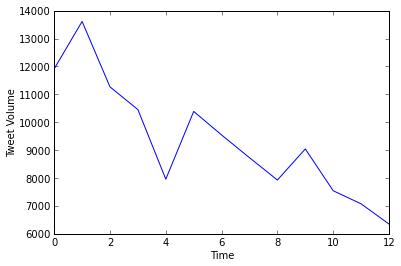

In [7]:
# Let's group the tweets by (hour, minute) and look at the overall volumes with a simple
# text-based histogram

def group_by_15_min_intervals(x):
    if   0 <= x.minute <= 15: return (x.hour, "0-15")
    elif 15 < x.minute <= 30: return (x.hour, "16-30")
    elif 30 < x.minute <= 45: return (x.hour, "31-45")
    else: return (x.hour, "46-00")


grouped = df.groupby(lambda x: group_by_15_min_intervals(x))

print "Number of relevant tweets by intervals (UTC)"
print

for interval, group in grouped:
    print interval, len(group), "\t", '*'*(len(group) / 200)

# Since we didn't start or end precisely on an interval, let's
# slice off the extremes. This has the added benefit of also
# improving the resolution of the plot that shows the trend
plt.plot([len(group) for hour, group in grouped][1:-1])
plt.ylabel("Tweet Volume")
plt.xlabel("Time")

In addition to time-based analysis, we can do other types of analysis as well. Generally speaking, one of the first things you'll want to do when exploring new data is count things, so let's compute the Twitter accounts that authored the most tweets and compare it to the total number of unique accounts that appeared.

In [8]:
from collections import Counter

# The "user" field is a record (dictionary), and we can pop it off
# and then use the Series constructor to make it easy to use with pandas.

user_col = df.pop('user').apply(pd.Series)

# Get the screen name column
authors = user_col.screen_name

# And count things
authors_counter = Counter(authors.values)

# And tally the totals

print
print "Most frequent (top 25) authors of tweets"
print '\n'.join(["{0}\t{1}".format(a, f) for a, f in authors_counter.most_common(25)])
print

# Get only the unique authors

num_unique_authors = len(set(authors.values))
print "There are {0} unique authors out of {1} tweets".format(num_unique_authors, len(df))


Most frequent (top 25) authors of tweets
_net_shop_	165
PC_shop_japan	161
work_black	160
house_book_jp	160
bousui_jp	147
Popular_goods	147
pachisuro_777	147
sweets_shop	146
bestshop_goods	146
__electronics__	142
realtime_trend	141
gardening_jp	140
shikaku_book	139
supplement_	139
__travel__	138
disc_jockey_jp	138
water_summer_go	138
Jungle_jp	137
necessaries_jp	137
marry_for_love	137
trend_realtime	136
sparkler_jp	136
PandoraQQ	133
flypfox	133
Promo_Culturel	132

There are 71794 unique authors out of 125681 tweets


At first glance, it would appear that there are quite a few bots accounting for a non-trivial portion of the tweet volume, and many of them appear to be Japanese! As usual, we can plot these values to get better intution about the underlying distrubution, so let's take a quick look at a frequency plot and histogram. We'll use logarithmic adjustments in both cases, so pay close attention to axis values.

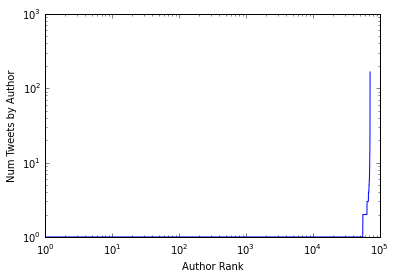

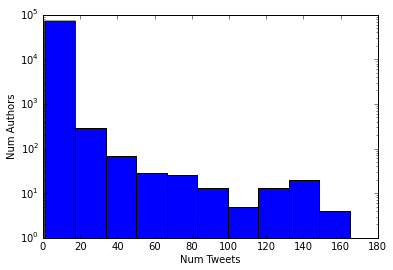

In [9]:
# Plot by rank (sorted value) to gain intution about the shape of the distrubtion

author_freqs = sorted(authors_counter.values())

plt.loglog(author_freqs)
plt.ylabel("Num Tweets by Author")
plt.xlabel("Author Rank")

# Start  a new figure

plt.figure()

# Plot a histogram to "zoom in" and increase resolution.

plt.hist(author_freqs, log=True)
plt.ylabel("Num Authors")
plt.xlabel("Num Tweets")

Although we could filter the DataFrame for coordinates (or locations in user profiles), an even simpler starting point to gain rudimentary insight about where users *might* be located is to inspect the language field of the tweets and compute the tallies for each language. With pandas, it's just a quick one-liner.

In [10]:
# What languages do authors of tweets speak? This might be a useful clue
# as to who is tweeting. (Also bear in mind the general timeframe for the 
# data when interpreting these results.)

df.lang.value_counts()

en     79151
ja     35940
und     3197
es      2713
de      1142
fr       717
id       442
pt       434
ko       283
vi       248
nl       212
th       209
zh       135
sk       114
ru        84
da        73
it        65
sl        65
pl        64
ht        63
et        56
tr        53
tl        43
ar        38
lt        30
no        17
lv        16
fi        15
hu        13
sv        12
bg         8
ne         7
el         5
he         5
fa         4
uk         3
my         2
is         2
ta         1
dtype: int64

A staggering number of Japanese speakers were talking about "Amazon" at the time the data was collected. Bearing in mind that it was already mid-day on Monday in Japan when it the news of the Amazon drones started to surface in the United States on Sunday evening, is this really all that surprising given Twitter's popularity in Japan?

Filtering on language also affords us to remove some noise from analysis since we can filter out only tweets in a specific language for inspection, which will be handy for some analysis on the content of the tweets themselves. Let's filter out only the 140 characters of text from tweets where the author speaks English and use some natural language processing techniques to learn more about the reaction.

In [11]:
# Let's just look at the content of the English tweets by extracting it
# out as a list of text

en_text = df[df['lang'] == 'en'].pop('text')

Although NLTK provides some advanced tokenization functions, let's just split the English text on white space, normalize it to lowercase, and remove some common trailing punctuation and count things to get an initial glance in to what's being talked about.

In [12]:
from collections import Counter

tokens = []
for txt in en_text.values:
    tokens.extend([t.lower().strip(":,.") for t in txt.split()])
    
# Use a Counter to construct frequency tuples
tokens_counter = Counter(tokens)

# Display some of the most commonly occurring tokens
tokens_counter.most_common(50)

[(u'amazon', 54778),
 (u'rt', 36409),
 (u'the', 25749),
 (u'drones', 24474),
 (u'to', 24040),
 (u'a', 21341),
 (u'delivery', 18557),
 (u'in', 17531),
 (u'of', 15741),
 (u'on', 14095),
 (u'drone', 13800),
 (u'by', 13422),
 (u'is', 12034),
 (u'for', 10988),
 (u'@amazon', 9318),
 (u'i', 9263),
 (u'and', 8793),
 (u'prime', 8783),
 (u'30', 8319),
 (u'air', 8026),
 (u'with', 7956),
 (u'future', 7911),
 (u'deliver', 7890),
 (u'get', 6790),
 (u'you', 6573),
 (u'your', 6543),
 (u'via', 6444),
 (u'deliveries', 6432),
 (u'this', 5899),
 (u'bezos', 5738),
 (u'will', 5703),
 (u'#primeair', 5680),
 (u'unmanned', 5442),
 (u'aerial', 5313),
 (u'under', 5308),
 (u'-', 5257),
 (u'mins', 5199),
 (u'that', 4890),
 (u'vehicles', 4835),
 (u'my', 4728),
 (u'from', 4720),
 (u'peek', 4699),
 (u'sneak', 4684),
 (u'unveils', 4555),
 (u'it', 4473),
 (u'minutes', 4459),
 (u'just', 4396),
 (u'at', 4394),
 (u'http://t.c\u2026', 4391),
 (u'packages', 4302)]

Not surprisingly, "amazon" is the most frequently occurring token, there are lots of retweets (actually, "quoted retweets") as evidenced by "rt", and lots of stopwords (commonly occurring words like "the", "and", etc.) at the top of the list. Let's further remove some of the noise by removing stopwords.

In [13]:
import nltk

# Download the stopwords list into NLTK

nltk.download('stopwords')

# Remove stopwords to decrease noise
for t in nltk.corpus.stopwords.words('english'):
    tokens_counter.pop(t)
    
# Redisplay the data (and then some)
tokens_counter.most_common(200)

[nltk_data] Downloading package 'stopwords' to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(u'amazon', 54778),
 (u'rt', 36409),
 (u'drones', 24474),
 (u'delivery', 18557),
 (u'drone', 13800),
 (u'@amazon', 9318),
 (u'prime', 8783),
 (u'30', 8319),
 (u'air', 8026),
 (u'future', 7911),
 (u'deliver', 7890),
 (u'get', 6790),
 (u'via', 6444),
 (u'deliveries', 6432),
 (u'bezos', 5738),
 (u'#primeair', 5680),
 (u'unmanned', 5442),
 (u'aerial', 5313),
 (u'-', 5257),
 (u'mins', 5199),
 (u'vehicles', 4835),
 (u'peek', 4699),
 (u'sneak', 4684),
 (u'unveils', 4555),
 (u'minutes', 4459),
 (u'http://t.c\u2026', 4391),
 (u'packages', 4302),
 (u'jeff', 4040),
 (u'http://t.co/w6kugw4egt', 3922),
 (u"amazon's", 3669),
 (u'flying', 3599),
 (u'ceo', 3205),
 (u'#amazon', 3074),
 (u'new', 2870),
 (u'free', 2797),
 (u'testing', 2585),
 (u'could', 2568),
 (u'shipping', 2541),
 (u'', 2422),
 (u'says', 2343),
 (u"'60", 2324),
 (u'like', 2300),
 (u'stuff', 2263),
 (u'years', 2194),
 (u'60', 2157),
 (u'use', 2134),
 (u'using', 1939),
 (u'&amp;', 1901),
 (u"minutes'", 1868),
 (u'kindle', 1735),
 (u"it'

What a difference removing a little bit of noise can make! We now see much more meaningful data appear at the top of the list: drones, signs that a phrase "30 mins" (which turned out to be a possible timeframe for a Prime Air delivery by a drone according to Bezos) might appear based the appearance of "30" and "mins"/"minutes" near the top of the list), signs of another phrase "prime air" (as evidenced by "prime", "air" and the hashtag "#primeair"), references to Jeff Bezos, URLs to investigate and more!

Even though we've already learned a lot, one of the challenges with only employing crude tokenization techniques is that you aren't left with any phrases. One of the simplest ways of disocvering meaningful phrases in text is to treat the problem as one of discovering statistical collocations. NLTK provides some routines to find collocations and includes a "demo" function that's a quick one-liner.

In [14]:
nltk_text = nltk.Text(tokens)
nltk_text.collocations()

Building collocations list
prime air; sneak peek; unmanned aerial; aerial vehicles;
http://t.co/w6kugw4egt http://t.c…; vehicles http://t.co/w6kugw4egt;
#primeair future; future deliveries; delivery drones; jeff bezos;
@amazon get; amazon prime; '60 minutes'; amazon unveils; cyber monday;
deliver packages; flying delivery; unveils flying; kindle fire; (also
helpful


Even without any prior analysis on tokenization, it's pretty clear what the topis is about as evidenced by this list of collocations. But what about the *context* in which these phrases appear? As it turns out, NLTK supplies another handy data structure that provides some insight as to how words appear in context called a concordance. Trying out the "demo functionality" for the concordance is as simple as just calling it as shown below. 

Toward the bottom of the list of commonly occurring tokens, the words "amazing" and "holy" appear. The word "amazing" is interesting, because it is usually the basis of an emotional reaction, and we're interested in examining the reaction. What about word "holy"? What might it mean? The concordance will help us to find out...

In [15]:
nltk_text.concordance("amazing")
print
nltk_text.concordance("holy")

Building index...
Displaying 25 of 508 matches:
s - @variety http://t.c… this looks amazing how will it impact drone traffic? -
it? amazon prime air delivery looks amazing http://t.co/icizw5vfrw rt @jeffreyg
gift card? @budgetearth &amp; other amazing bloggers are giving one away! ends 
k? damn that amazon prime air looks amazing im sure it would freak out some peo
egt http://t.c… @munilass amazon is amazing for what i use it for i'm okay with
wwglyqrq just in bonnie sold again! amazing book http://t.co/jce902iros #best-s
ase of 1000) http://t.co/d6l8p3jgbz amazing prospects! “@brianstelter on heels 
riety http://t.c… rt @dangillmor by amazing coincidence amazon had a youtube dr
rd_ferguson amazon prime air sounds amazing *hot* kindle fire hdx wi-fi 7' tabl
t.co/hrgxtrlumx this is going to be amazing if the faa allows it welcome to the
lying grill #primeair is absolutely amazing i'm excited to see the progress/dev
.co/w6kugw4egt http://t.c… the most amazing thing to me about amazon - w

It would appear that there is indeed a common thread of amazement in the data, and it's evident that @joshuatopolsky (who turns out to be Editor-in-chief of <a href="http://www.theverge.com/">The Verge</a>) is a commonly occurring tweet entity that warrants further investigation. Speaking of tweet entities, let's take an initial look at usernames, hashtags, and URLs by employing a simple heuristic to look for words prefixed with @, RT, #, and http to see what some of the most commonly occurring tweet entiteis are in the data.

In [16]:
# An crude look at tweet entities

entities = []
for txt in en_text.values:
    for t in txt.split():
        if t.startswith("http") or t.startswith("@") or t.startswith("#") or t.startswith("RT @"):
            if not t.startswith("http"):
                t = t.lower()
            entities.append(t.strip(" :,"))

entities_counter = Counter(entities)
for entity, freq in entities_counter.most_common()[:100]:
    print entity, freq

@amazon 8994
#primeair. 4767
http://t.c… 4391
http://t.co/w6kugw4EGt 3922
#amazon 3032
@60minutes 1325
#primeair 911
@mashable 787
@buzzfeed 774
@amazondrone 743
@bradplumer 743
@deathstarpr 735
#drones 729
http://t.co/JlFdNiHzks 711
http://t.co/BxSAVVzXZf 690
@badbanana 570
#kindle 467
@thenextweb 458
#amexamazon 441
http://t.co/MHqFG… 434
#giveaway 421
http:/… 417
#win 409
http:… 406
@techcrunch 391
#drone 383
#60minutes 380
http://t… 357
#tech 342
@levie 340
@variety 337
@breakingnews 331
@youtube 326
#cybermonday 325
@huffposttech 322
http://… 320
@jonrussell 304
@realjohngreen 300
#news 298
http://t.co/FNndPuMouA 294
@washingtonpost 284
@kotaku 283
@usatoday 283
http://t.… 280
#amazondrones 278
@nycjim 277
http://t.co/NG8… 270
http://t.co/rUu14XpvGo 270
@brianstelter 268
@majornelson 260
@benbadler 258
http://t.co/M7kqd26jVR 255
http… 254
@businessinsider 249
@huffingtonpost 245
http://t.co/DOEjXCC1vL 241
@sai 241
http://t.co/… 240
@verge 237
http://t.co/tAVunIXxo3 230
http://t.co

As you can see, there are lots of intersting tweet entities that give you helpful context for the announcement. One particularly notable observation is the appearance of "comedic accounts" such as @deathstarpr and @amazondrone near the top of the list, relaying a certain amount of humor. The <a href="https://twitter.com/DeathStarPR/status/407335634940878848">tweet</a> embedded below that references *Star Wars* was eventually retweeted over 1k times in response to the announcement! It wouldn't be difficult to determine how many retweets occurred just within the ~3 hour timeframe corresponding to the dataset we're using here.

<center>
<blockquote class="twitter-tweet" lang="en"><p>First look at Amazon&#39;s new delivery drone. (Also helpful for finding Rebel bases on Hoth.) <a href="http://t.co/JlFdNiHzks">pic.twitter.com/JlFdNiHzks</a></p>&mdash; Death Star PR (@DeathStarPR) <a href="https://twitter.com/DeathStarPR/statuses/407335634940878848">December 2, 2013</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
</center>

When you take a closer look at some of the developed news stories, you also see sarcasm, unbelief, and even a bit of frustration about this being a "publicity stunt" for Cyber Monday.

Note: There proper way of parsing out tweet entities from the *entities* field that you can see in the DataFrame. It's marginally more work but has the primary advantage that you can see the "expanded URL" which provides better insight into the nature of the URL since you'll know its domain name. See <a href="http://nbviewer.ipython.org/github/ptwobrussell/Mining-the-Social-Web-2nd-Edition/blob/master/ipynb/Chapter%209%20-%20Twitter%20Cookbook.ipynb#Example-10.-Extracting-tweet-entities">Example 9-10, Extracting Tweet Entities</a> from *Mining the Social Web* for more on how to do that.

## Summarize

We *aspired* to learn more about the general reaction to Amazon's announcement about Prime Air by taking an initial look at the data from Amazon's firehose, and it's fair to say that we learned a few things about the data without too much effort. Lots more could be discovered, but a few of the themes that we were able to glean included:

* Amazement
* Humor
* Disbelief

Although these reactions aren't particularly surprising for such an outrageous announcement, you've hopefully learned enough that you could tap into Twitter's firehose to capture and analyze data that's of interest to you. There is no shortage of fun to be had, and as you've learned, it's easier than it might first appear.

Enjoy!

## Recommended Resources

If you enjoy analyzing data from social websites like Twitter, then you might enjoy the book *Mining the Social Web, 2nd Edition* (O'Reilly). You can learn more about it at <a href="http://MiningTheSocialWeb.com">MiningTheSocialWeb.com</a>. All source code is available in IPython Notebook format at <a href="http://bit.ly/MiningTheSocialWeb2E">GitHub</a> and can be previewed in the <a href="http://bit.ly/1cOlK6q">IPython Notebook Viewer</a>.

The book itself is a form of "premium support" for the source code and is available for purchase from <a href="http://amzn.to/GPd59m">Amazon</a> or <a href="http://bit.ly/135dHfs">O'Reilly Media</a>.